# Cross-Domain Neural Networks for JPEG Decompression (ImageNet)

This Jupyter Notebook trains U-net and W-net models for JPEG decompression.

Network 1: Image-domain U-net

Network 2: DCT-domain U-net (apply DCT on 8x8 blocks of the image)

Network 3: DCT-Image-domain W-net (use the results from Network (2) to train Network (1))

Network 4: Image-Image-domain W-net

Network 5: DCT-DCT-domain W-net (apply DCT on 8x8 blocks of the image)

Details:
- On the fly data augmentation
- JPEG quality varying between 10-20
- Dropout

In [1]:
%matplotlib inline
from __future__ import print_function, division
import matplotlib.pylab as plt
import numpy as np
from keras.optimizers import Adam
import os
import glob
import io
from PIL import Image
import sys
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.backend import eval as tf_eval

# Importing our U-Net model
MY_UTILS_PATH = "../Modules/"
if not MY_UTILS_PATH in sys.path:
    sys.path.append(MY_UTILS_PATH)
from cs_models import deep_cascade_unet_no_dc
from models import my_unet
from dctools import dct_in_blocks, idct_in_blocks, py_dct2d, py_idct2d

Using TensorFlow backend.


# Network A: Image W-net

In [2]:
# Train and validation data paths
train_path = "/home/ubuntu/volume/volume1/TIFF/Development/Training/*.tif"
val_path = "/home/ubuntu/volume/volume1/TIFF/Development/Validation/*.tif"

# Listing train and validation images
train_images = glob.glob(train_path)
val_images = glob.glob(val_path)

# Summary of images
print("Train set size:", len(train_images))
print("Validation set size:",len(val_images))

Train set size: 10740
Validation set size: 5370


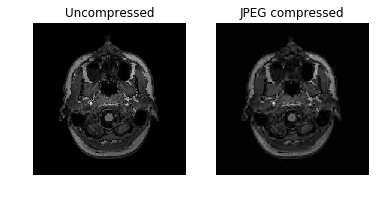

In [3]:
# Load uncompressed image
im1 = Image.open(train_images[200])
im1_array = np.array(im1)

# JPEG compress the image    
buffer = io.BytesIO()
im1.save(buffer, "JPEG", quality=15)
im2 = Image.open(buffer)
im2_array = np.array(im2)

# Display the images
plt.figure()
plt.subplot(121)
plt.imshow(im1_array,cmap = "gray")
plt.axis("off")
plt.title("Uncompressed")
plt.subplot(122)
plt.imshow(im2_array,cmap = "gray")
plt.axis("off")
plt.title("JPEG compressed")
plt.show()

In [4]:
H,W = 256, 256
norm = 255.0
compr_range = (5,6)

compr = np.random.choice(np.arange(compr_range[0],compr_range[1], dtype=int), \
                               len(train_images),replace = True)

# Train set
train_unc = np.zeros((len(train_images),H,W,1),dtype = np.float32)
for ii in range(len(train_images)):
    # Load uncompressed image
    im1 = Image.open(train_images[ii])
    train_unc[ii,:,:,0] = np.array(im1,dtype=np.float32)

    
compr_val = np.random.choice(np.arange(compr_range[0],compr_range[1], dtype=int), \
                               len(val_images),replace = True)

# Validation set
val_unc = np.zeros((len(val_images),H,W,1),dtype = np.float32)
val_compr = val_unc.copy()

for ii in range(len(val_images)):
    # Load uncompressed image
    im1 = Image.open(val_images[ii])
    val_unc[ii,:,:,0] = np.array(im1,dtype=np.float32)

    # JPEG compress the image    
    buffer = io.BytesIO()
    im1.save(buffer, "JPEG", quality=int(compr_val[ii]))
    im2 = Image.open(buffer)
    val_compr[ii,:,:,0] = np.array(im2,dtype=np.float32)


# Centre data around 0 and normalize to [-1, 1)
val_unc -= 128.0
val_compr -= 128.0

val_unc /= 128.0
val_compr /= 128.0

In [5]:
num_network = 1

epochs = 30
batch_size= 8
model_name = "../Models/single_qf/20190408-pretrained-residual_unet_i_data_augmentation_compress_5.hdf5"

# Early stopping callback to shut down training after 10 epochs with no improvement
earlyStopping = EarlyStopping(monitor='val_loss',
                                       patience=20, 
                                       verbose=0, mode='min')

checkpoint = ModelCheckpoint(model_name, mode = 'min', \
                                 monitor='val_loss',verbose=0,\
                                 save_best_only=True, save_weights_only = True)

if num_network == 1:
    depth_str ='i'
elif num_network == 2:
    depth_str = 'd'
elif num_network == 3:
    depth_str = 'di'
elif num_network == 4:
    depth_str = 'ii'
elif num_network == 5:
    depth_str = 'dd'
else:
    depth_str = 'ii'

opt = Adam(lr=0.0001)
model = deep_cascade_unet_no_dc(depth_str)
model.compile(loss = "mse",optimizer=opt)

model.load_weights("../Models/single_qf/20190321-imagenet-residual_unet_i_data_augmentation_compress_5.hdf5")

Instructions for updating:
Colocations handled automatically by placer.
0 i
Append U-net block


In [6]:
seed = 905
image_datagen1 = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.075,
        height_shift_range=0.075,
        shear_range=0.25,
        zoom_range=0.25,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')

image_datagen1.fit(train_unc, augment=True, seed=seed)

image_generator1 = image_datagen1.flow(train_unc,batch_size = batch_size,seed = seed)

def combine_generator(gen1,compr_range):
    while True:
        batch_unc = gen1.next()
        batch_comp = np.zeros_like(batch_unc)

        for ii in range(batch_unc.shape[0]):
            # JPEG compress the image    
            im1 = Image.fromarray(np.uint8(batch_unc[ii,:,:,0]))
            buffer = io.BytesIO()
            im1.save(buffer, "JPEG", quality=int(compr[ii]))
            im2 = Image.open(buffer)
            batch_comp[ii,:,:,0] = np.array(im2,dtype=np.float32)
            
        yield((batch_comp-128.0)/128.0, (batch_unc.astype(np.float32)-128.0)/128.0)

# combine generators into one which yields image and masks
combined = combine_generator(image_generator1,compr_range)

(8, 256, 256, 1)
-1.0 0.9609375
-1.0 0.7414646


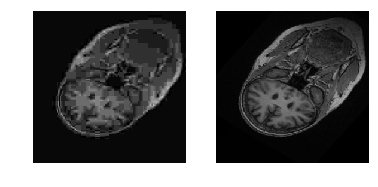

In [7]:
# sample data augmentation
for ii in combined:
    print(ii[0].shape)
    print(ii[0].min(),ii[0].max())
    print(ii[1].min(),ii[1].max())
    plt.figure()
    plt.subplot(121)
    plt.imshow(ii[0][2,:,:,0],cmap = 'gray',vmin=-1,vmax=1)
    plt.axis("off")
    plt.subplot(122)
    plt.imshow(ii[1][2,:,:,0],cmap = 'gray',vmin=-1,vmax=1)
    plt.axis("off")
    plt.show()
    break

In [8]:
hist = model.fit_generator(combined,
                 epochs=epochs,
                 steps_per_epoch=train_unc.shape[0] / batch_size,
                 verbose=1,
                 validation_data= (val_compr,val_unc),
                 callbacks=[checkpoint,earlyStopping])

Instructions for updating:
Use tf.cast instead.
Epoch 1/30
1343/1342 [==============================] - 131s 98ms/step - loss: 0.0031 - val_loss: 0.0043
Epoch 2/30
1343/1342 [==============================] - 127s 95ms/step - loss: 0.0031 - val_loss: 0.0043
Epoch 3/30
1343/1342 [==============================] - 127s 94ms/step - loss: 0.0031 - val_loss: 0.0043
Epoch 4/30
1343/1342 [==============================] - 127s 95ms/step - loss: 0.0030 - val_loss: 0.0043
Epoch 5/30
1343/1342 [==============================] - 127s 95ms/step - loss: 0.0030 - val_loss: 0.0042
Epoch 6/30
1343/1342 [==============================] - 127s 95ms/step - loss: 0.0030 - val_loss: 0.0042
Epoch 7/30
1343/1342 [==============================] - 127s 95ms/step - loss: 0.0030 - val_loss: 0.0042
Epoch 8/30
1343/1342 [==============================] - 127s 95ms/step - loss: 0.0030 - val_loss: 0.0042
Epoch 9/30
1343/1342 [==============================] - 127s 94ms/step - loss: 0.0030 - val_loss: 0.0042
Epoch 1

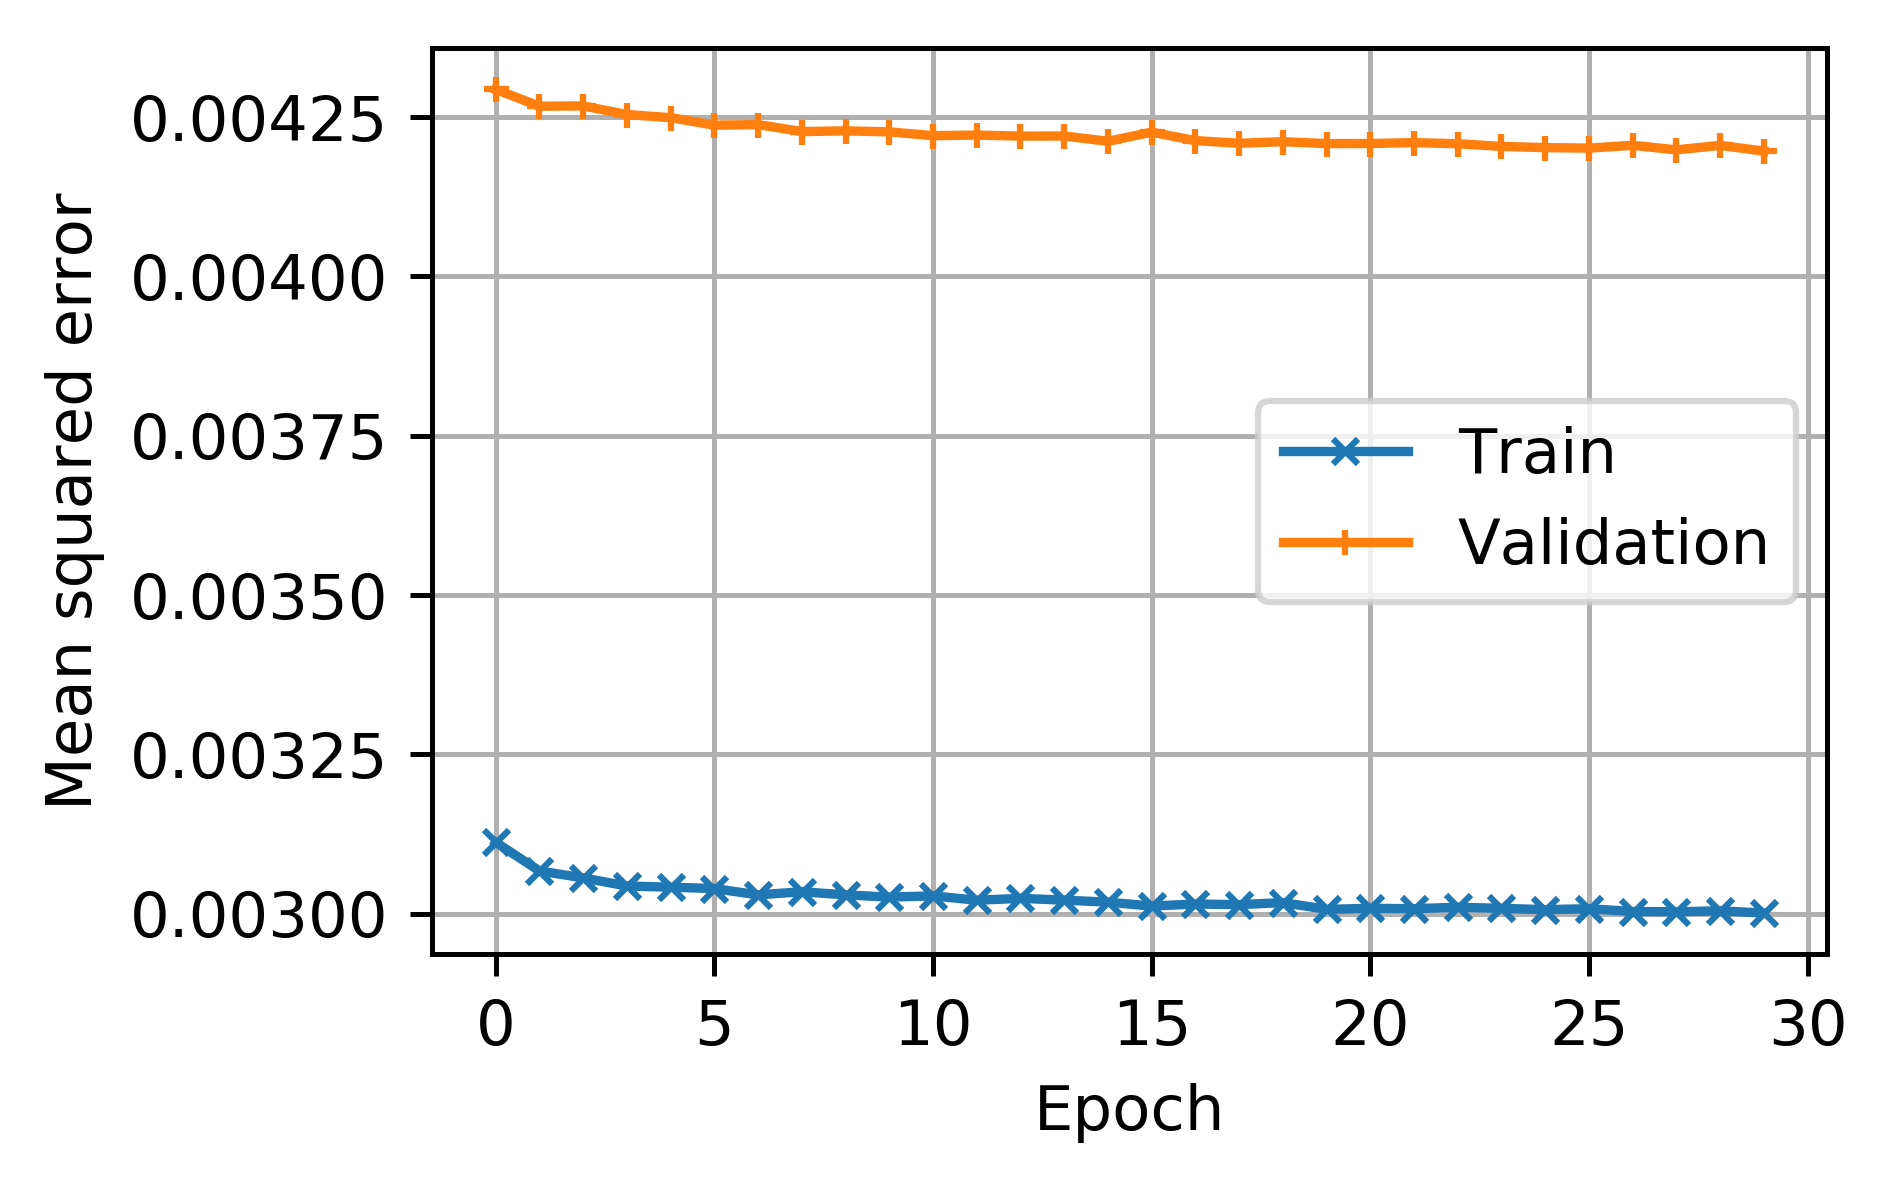

In [9]:
#Saving training history
np.save("../Data/single_qf/loss_residual_unet_i_data_augmentation_compress_5-pretrained.npy",np.array(hist.history['loss']))
np.save("../Data/single_qf/val_loss_residual_unet_i_data_augmentation_compress_5-pretrained.npy",np.array(hist.history['val_loss']))

loss = np.array(hist.history['loss'])
val_loss = np.array(hist.history['val_loss'])
plt.figure(figsize = (4,4/1.5),facecolor = "w",dpi = 450)
plt.plot(loss,'x-', markersize = 4,label = "Train")
plt.plot(val_loss,'+-',markersize = 4,label = "Validation")
plt.legend()
plt.grid()
plt.xlabel("Epoch")
plt.ylabel("Mean squared error")
plt.show()

# Network B: DCT W-net

In [10]:
# Train and validation data paths
train_path = "/home/ubuntu/volume/volume1/TIFF/Development/Training/*.tif"
val_path = "/home/ubuntu/volume/volume1/TIFF/Development/Validation/*.tif"

# Listing train and validation images
train_images = glob.glob(train_path)
val_images = glob.glob(val_path)

# Summary of images
print("Train set size:", len(train_images))
print("Validation set size:",len(val_images))

Train set size: 10740
Validation set size: 5370


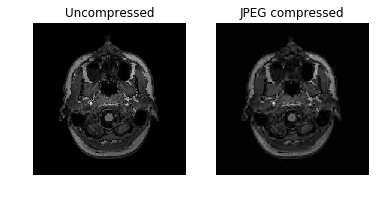

In [11]:
# Load uncompressed image
im1 = Image.open(train_images[200])
im1_array = np.array(im1)

# JPEG compress the image    
buffer = io.BytesIO()
im1.save(buffer, "JPEG", quality=15)
im2 = Image.open(buffer)
im2_array = np.array(im2)

# Display the images
plt.figure()
plt.subplot(121)
plt.imshow(im1_array,cmap = "gray")
plt.axis("off")
plt.title("Uncompressed")
plt.subplot(122)
plt.imshow(im2_array,cmap = "gray")
plt.axis("off")
plt.title("JPEG compressed")
plt.show()

In [12]:
H,W = 256, 256
norm = 255.0
compr_range = (5,6)

compr = np.random.choice(np.arange(compr_range[0],compr_range[1], dtype=int), \
                               len(train_images),replace = True)

# Train set
train_unc = np.zeros((len(train_images),H,W,1),dtype = np.float32)
for ii in range(len(train_images)):
    # Load uncompressed image
    im1 = Image.open(train_images[ii])
    train_unc[ii,:,:,0] = np.array(im1,dtype=np.float32)

    
compr_val = np.random.choice(np.arange(compr_range[0],compr_range[1], dtype=int), \
                               len(val_images),replace = True)

# Validation set
val_unc = np.zeros((len(val_images),H,W,1),dtype = np.float32)
val_compr = val_unc.copy()

for ii in range(len(val_images)):
    # Load uncompressed image
    im1 = Image.open(val_images[ii])
    val_unc[ii,:,:,0] = np.array(im1,dtype=np.float32)

    # JPEG compress the image    
    buffer = io.BytesIO()
    im1.save(buffer, "JPEG", quality=int(compr_val[ii]))
    im2 = Image.open(buffer)
    val_compr[ii,:,:,0] = np.array(im2,dtype=np.float32)


# Centre data around 0 and normalize to [-1, 1)
val_unc -= 128.0
val_compr -= 128.0

val_unc /= 128.0
val_compr /= 128.0

In [13]:
# DCT of validation set
dct_val_unc = val_unc.copy()
dct_val_compr = val_unc.copy()

for ii in range(len(val_images)):
    dct_val_unc[ii,:,:,0] = dct_in_blocks(val_unc[ii,:,:,0])
    dct_val_compr[ii,:,:,0] = dct_in_blocks(val_compr[ii,:,:,0])

In [14]:
num_network = 1

epochs = 30
batch_size= 8
model_name = "../Models/20190408-pretrained-residual_unet_d_data_augmentation_compress_5.hdf5"

# Early stopping callback to shut down training after 10 epochs with no improvement
earlyStopping = EarlyStopping(monitor='val_loss',
                                       patience=20, 
                                       verbose=0, mode='min')

checkpoint = ModelCheckpoint(model_name, mode = 'min', \
                                 monitor='val_loss',verbose=0,\
                                 save_best_only=True, save_weights_only = True)

if num_network == 1:
    depth_str ='i'
elif num_network == 2:
    depth_str = 'd'
elif num_network == 3:
    depth_str = 'di'
elif num_network == 4:
    depth_str = 'ii'
elif num_network == 5:
    depth_str = 'dd'
else:
    depth_str = 'ii'

opt = Adam(lr=0.0001)
model = deep_cascade_unet_no_dc(depth_str)
model.compile(loss = "mse",optimizer=opt)

model.load_weights("../Models/single_qf/20190322-imagenet-residual_unet_d_data_augmentation_compress_5.hdf5")

0 i
Append U-net block


In [15]:
# Data augmentation
# Question - should we take the DCT of the augmented image or augment the DCT matrix?
# Mar 6 --> Try augmenting the DCT matrix image
# augment before or after DCT?

seed = 905
image_datagen1 = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.075,
        height_shift_range=0.075,
        shear_range=0.25,
        zoom_range=0.25,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')

image_datagen1.fit(train_unc, augment=True, seed=seed)

image_generator1 = image_datagen1.flow(train_unc,batch_size = batch_size,seed = seed)

def combine_generator(gen1,compr_range):
    while True:
        batch_unc = gen1.next()
        batch_comp = np.zeros_like(batch_unc)
        
        dct_batch_unc = batch_unc.copy()
        dct_batch_comp = batch_comp.copy()

        compr = np.random.choice(np.arange(compr_range[0],compr_range[1], dtype=int), \
                               batch_unc.shape[0],replace = True)

        for ii in range(batch_unc.shape[0]):
            # JPEG compress the image    
            im1 = Image.fromarray(np.uint8(batch_unc[ii,:,:,0]))
            buffer = io.BytesIO()
            im1.save(buffer, "JPEG", quality=int(compr[ii]))
            im2 = Image.open(buffer)
            batch_comp[ii,:,:,0] = np.array(im2,dtype=np.float32)

            dct_batch_unc[ii,:,:,0] = dct_in_blocks((batch_unc[ii,:,:,0].astype(np.float32)-128.0)/128.0)
            dct_batch_comp[ii,:,:,0] = dct_in_blocks((batch_comp[ii,:,:,0].astype(np.float32)-128.0)/128.0)
            
        yield(dct_batch_comp, dct_batch_unc)

# combine generators into one which yields image and masks
combined = combine_generator(image_generator1,compr_range)

(8, 256, 256, 1)
-7.5 4.2980566
-7.9999995 3.9439158


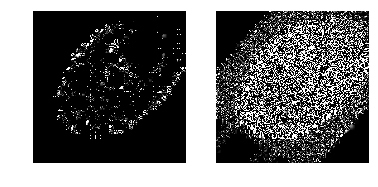

In [16]:
# sample data augmentation
for ii in combined:
    print(ii[0].shape)
    print(ii[0].min(),ii[0].max())
    print(ii[1].min(),ii[1].max())
    plt.figure()
    plt.subplot(121)
    plt.imshow(ii[0][2,:,:,0],cmap = 'gray',vmin=0,vmax=1/128.0)
    plt.axis("off")
    plt.subplot(122)
    plt.imshow(ii[1][2,:,:,0],cmap = 'gray',vmin=0,vmax=1/128.0)
    plt.axis("off")
    plt.show()
    break

In [17]:
hist = model.fit_generator(combined,
                 epochs=epochs,
                 steps_per_epoch=train_unc.shape[0] / batch_size,
                 verbose=1,
                 validation_data= (dct_val_compr,dct_val_unc),
                 callbacks=[checkpoint,earlyStopping])

Epoch 1/30
1343/1342 [==============================] - 472s 352ms/step - loss: 0.0032 - val_loss: 0.0044
Epoch 2/30
1343/1342 [==============================] - 465s 346ms/step - loss: 0.0031 - val_loss: 0.0044
Epoch 3/30
1343/1342 [==============================] - 469s 349ms/step - loss: 0.0031 - val_loss: 0.0044
Epoch 4/30
1343/1342 [==============================] - 466s 347ms/step - loss: 0.0031 - val_loss: 0.0044
Epoch 5/30
1343/1342 [==============================] - 466s 347ms/step - loss: 0.0031 - val_loss: 0.0043
Epoch 6/30
1343/1342 [==============================] - 465s 346ms/step - loss: 0.0031 - val_loss: 0.0043
Epoch 7/30
1343/1342 [==============================] - 471s 350ms/step - loss: 0.0031 - val_loss: 0.0043
Epoch 8/30
1343/1342 [==============================] - 466s 347ms/step - loss: 0.0031 - val_loss: 0.0043
Epoch 9/30
1343/1342 [==============================] - 467s 347ms/step - loss: 0.0031 - val_loss: 0.0043
Epoch 10/30
1343/1342 [=======================

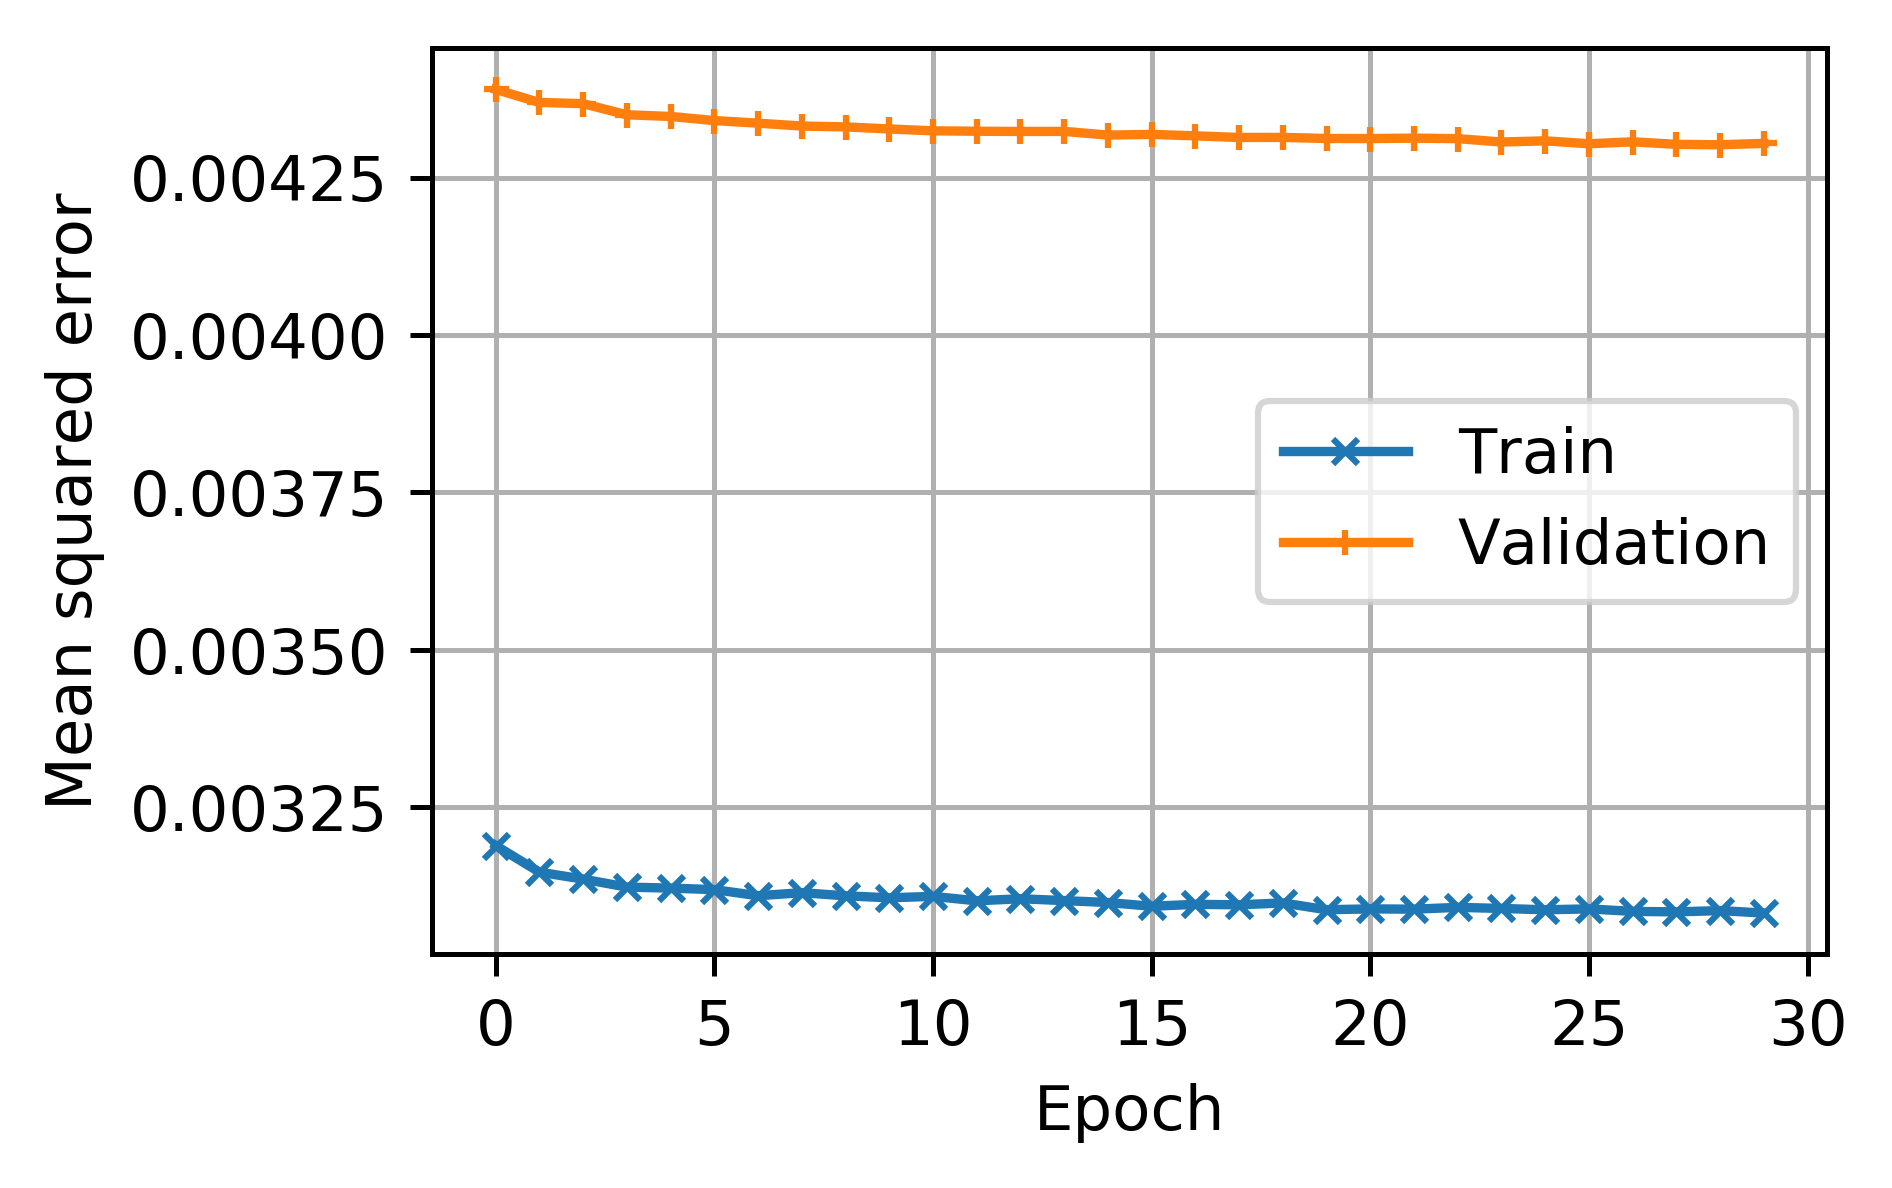

In [18]:
#Saving training history
np.save("../Data/single_qf/loss_residual_unet_d_data_augmentation_compress_5-pretrained.npy",np.array(hist.history['loss']))
np.save("../Data/single_qf/val_loss_residual_unet_d_data_augmentation_compress_5-pretrained.npy",np.array(hist.history['val_loss']))

loss = np.array(hist.history['loss'])
val_loss = np.array(hist.history['val_loss'])
plt.figure(figsize = (4,4/1.5),facecolor = "w",dpi = 450)
plt.plot(loss,'x-', markersize = 4,label = "Train")
plt.plot(val_loss,'+-',markersize = 4,label = "Validation")
plt.legend()
plt.grid()
plt.xlabel("Epoch")
plt.ylabel("Mean squared error")
plt.show()

# Network C: DCT-Image W-net

In [2]:
# Train and validation data paths
train_path = "/home/ubuntu/volume/volume1/TIFF/Development/Training/*.tif"
val_path = "/home/ubuntu/volume/volume1/TIFF/Development/Validation/*.tif"

# Listing train and validation images
train_images = sorted(glob.glob(train_path))
val_images = sorted(glob.glob(val_path))

# Summary of images
print("Train set size:", len(train_images))
print("Validation set size:",len(val_images))

Train set size: 10740
Validation set size: 5370


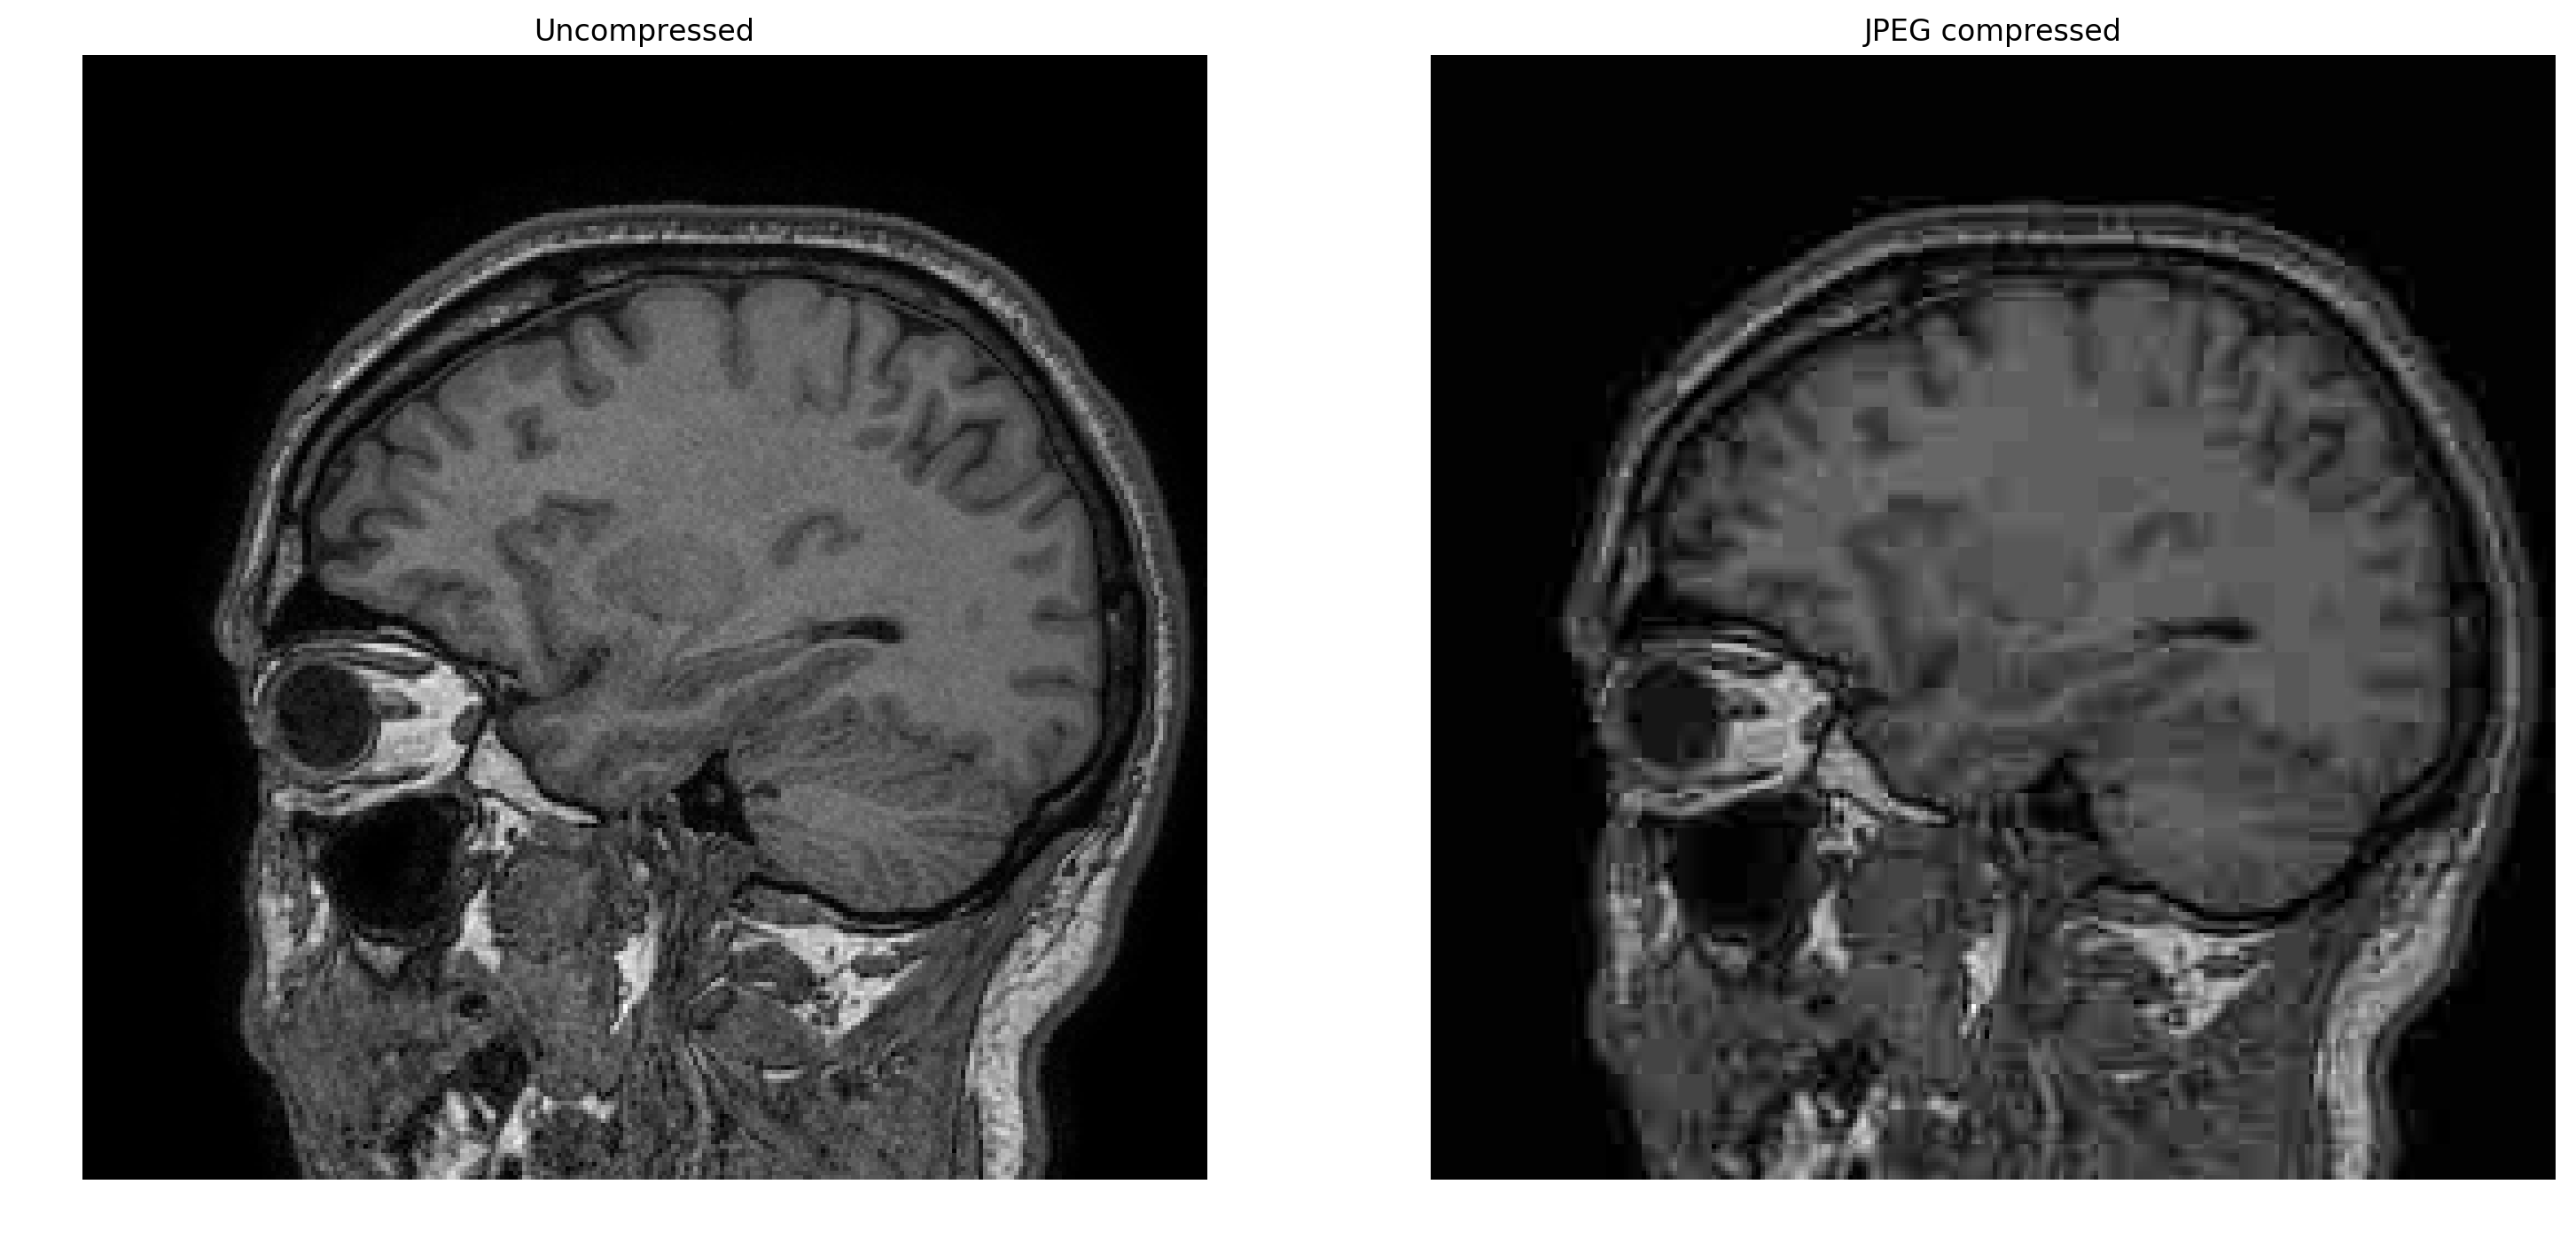

In [3]:
# Load uncompressed image
im1 = Image.open(train_images[658])
im1_array = np.array(im1)

# JPEG compress the image    
buffer = io.BytesIO()
im1.save(buffer, "JPEG", quality=15)
im2 = Image.open(buffer)
im2_array = np.array(im2)

# Display the images
plt.figure(figsize=(18,9),dpi=200)
plt.subplot(1,2,1)
plt.imshow(im1_array,cmap = "gray")
plt.axis("off")
plt.title("Uncompressed")
plt.subplot(1,2,2)
plt.imshow(im2_array,cmap = "gray")
plt.axis("off")
plt.title("JPEG compressed")
plt.show()

In [4]:
H,W = 256, 256
norm = 255.0
compr_range = (5,6)

loadFromFile = True
useNoise = False

pseudo_train_path = "../np_imagedata/single_qf/train_20190408-pretrained-residual_unet_d_data_augmentation_compress_5_2019-04-09.npy"
pseudo_val_path = "../np_imagedata/single_qf/val_20190408-pretrained-residual_unet_d_data_augmentation_compress_5_2019-04-09.npy"
 
train_unc = np.zeros((len(train_images),H,W,1),dtype = np.float32)
compr_train = np.random.choice(np.arange(compr_range[0],compr_range[1], dtype=int), \
                               len(train_images),replace = True)
val_unc = np.zeros((len(val_images),H,W,1),dtype = np.float32)
compr_val = np.random.choice(np.arange(compr_range[0],compr_range[1], dtype=int), \
                               len(val_images),replace = True)

train_compr = train_unc.copy()
val_compr = val_unc.copy()

# Train set
for ii in range(len(train_images)):
    # Load uncompressed image
    im1 = Image.open(train_images[ii])
    train_unc[ii,:,:,0] = np.array(im1, dtype=np.float32)
    
#     if loadFromFile:
#         im2 = Image.open(train_images[ii])
#         train_compr[ii,:,:,0] = np.array(im2, dtype=np.float32)
#     else:
    # JPEG compress the image    
    buf = io.BytesIO()
    im1.save(buf, "JPEG", quality=int(compr_train[ii]))
    im2 = Image.open(buf)
    train_compr[ii,:,:,0] = np.array(im2, dtype=np.float32)
        
# Validation set
for ii in range(len(val_images)):
    # Load uncompressed image
    im1 = Image.open(val_images[ii])
    val_unc[ii,:,:,0] = np.array(im1, dtype=np.float32)

#     if loadFromFile:
#         # JPEG compress the image
#         im2 = Image.open(val_images[ii])
#         val_compr[ii,:,:,0] = np.array(im2, dtype=np.float32)
#     else:
    # JPEG compress the image    
    buf = io.BytesIO()
    im1.save(buf, "JPEG", quality=int(compr_val[ii]))
    im2 = Image.open(buf)
    val_compr[ii,:,:,0] = np.array(im2, dtype=np.float32)
        

if loadFromFile:
    train_compr = np.load(pseudo_train_path)
    val_compr = np.load(pseudo_val_path)

if useNoise:
    for ii in range(len(train_images)):
        train_compr[ii,:,:,0] = train_compr[ii,:,:,0] + \
        np.random.normal(train_compr[ii,:,:,0].mean(), train_compr[ii,:,:,0].std(), train_compr[ii,:,:,0].shape)
    for ii in range(len(val_images)):
        val_compr[ii,:,:,0] = val_compr[ii,:,:,0] + \
        np.random.normal(val_compr[ii,:,:,0].mean(), val_compr[ii,:,:,0].std(), val_compr[ii,:,:,0].shape)

train_unc -= 128.0
train_unc /= 128.0

train_compr -= 128.0
train_compr /= 128.0
        
val_unc -= 128.0
val_unc /= 128.0

val_compr -= 128.0
val_compr /= 128.0

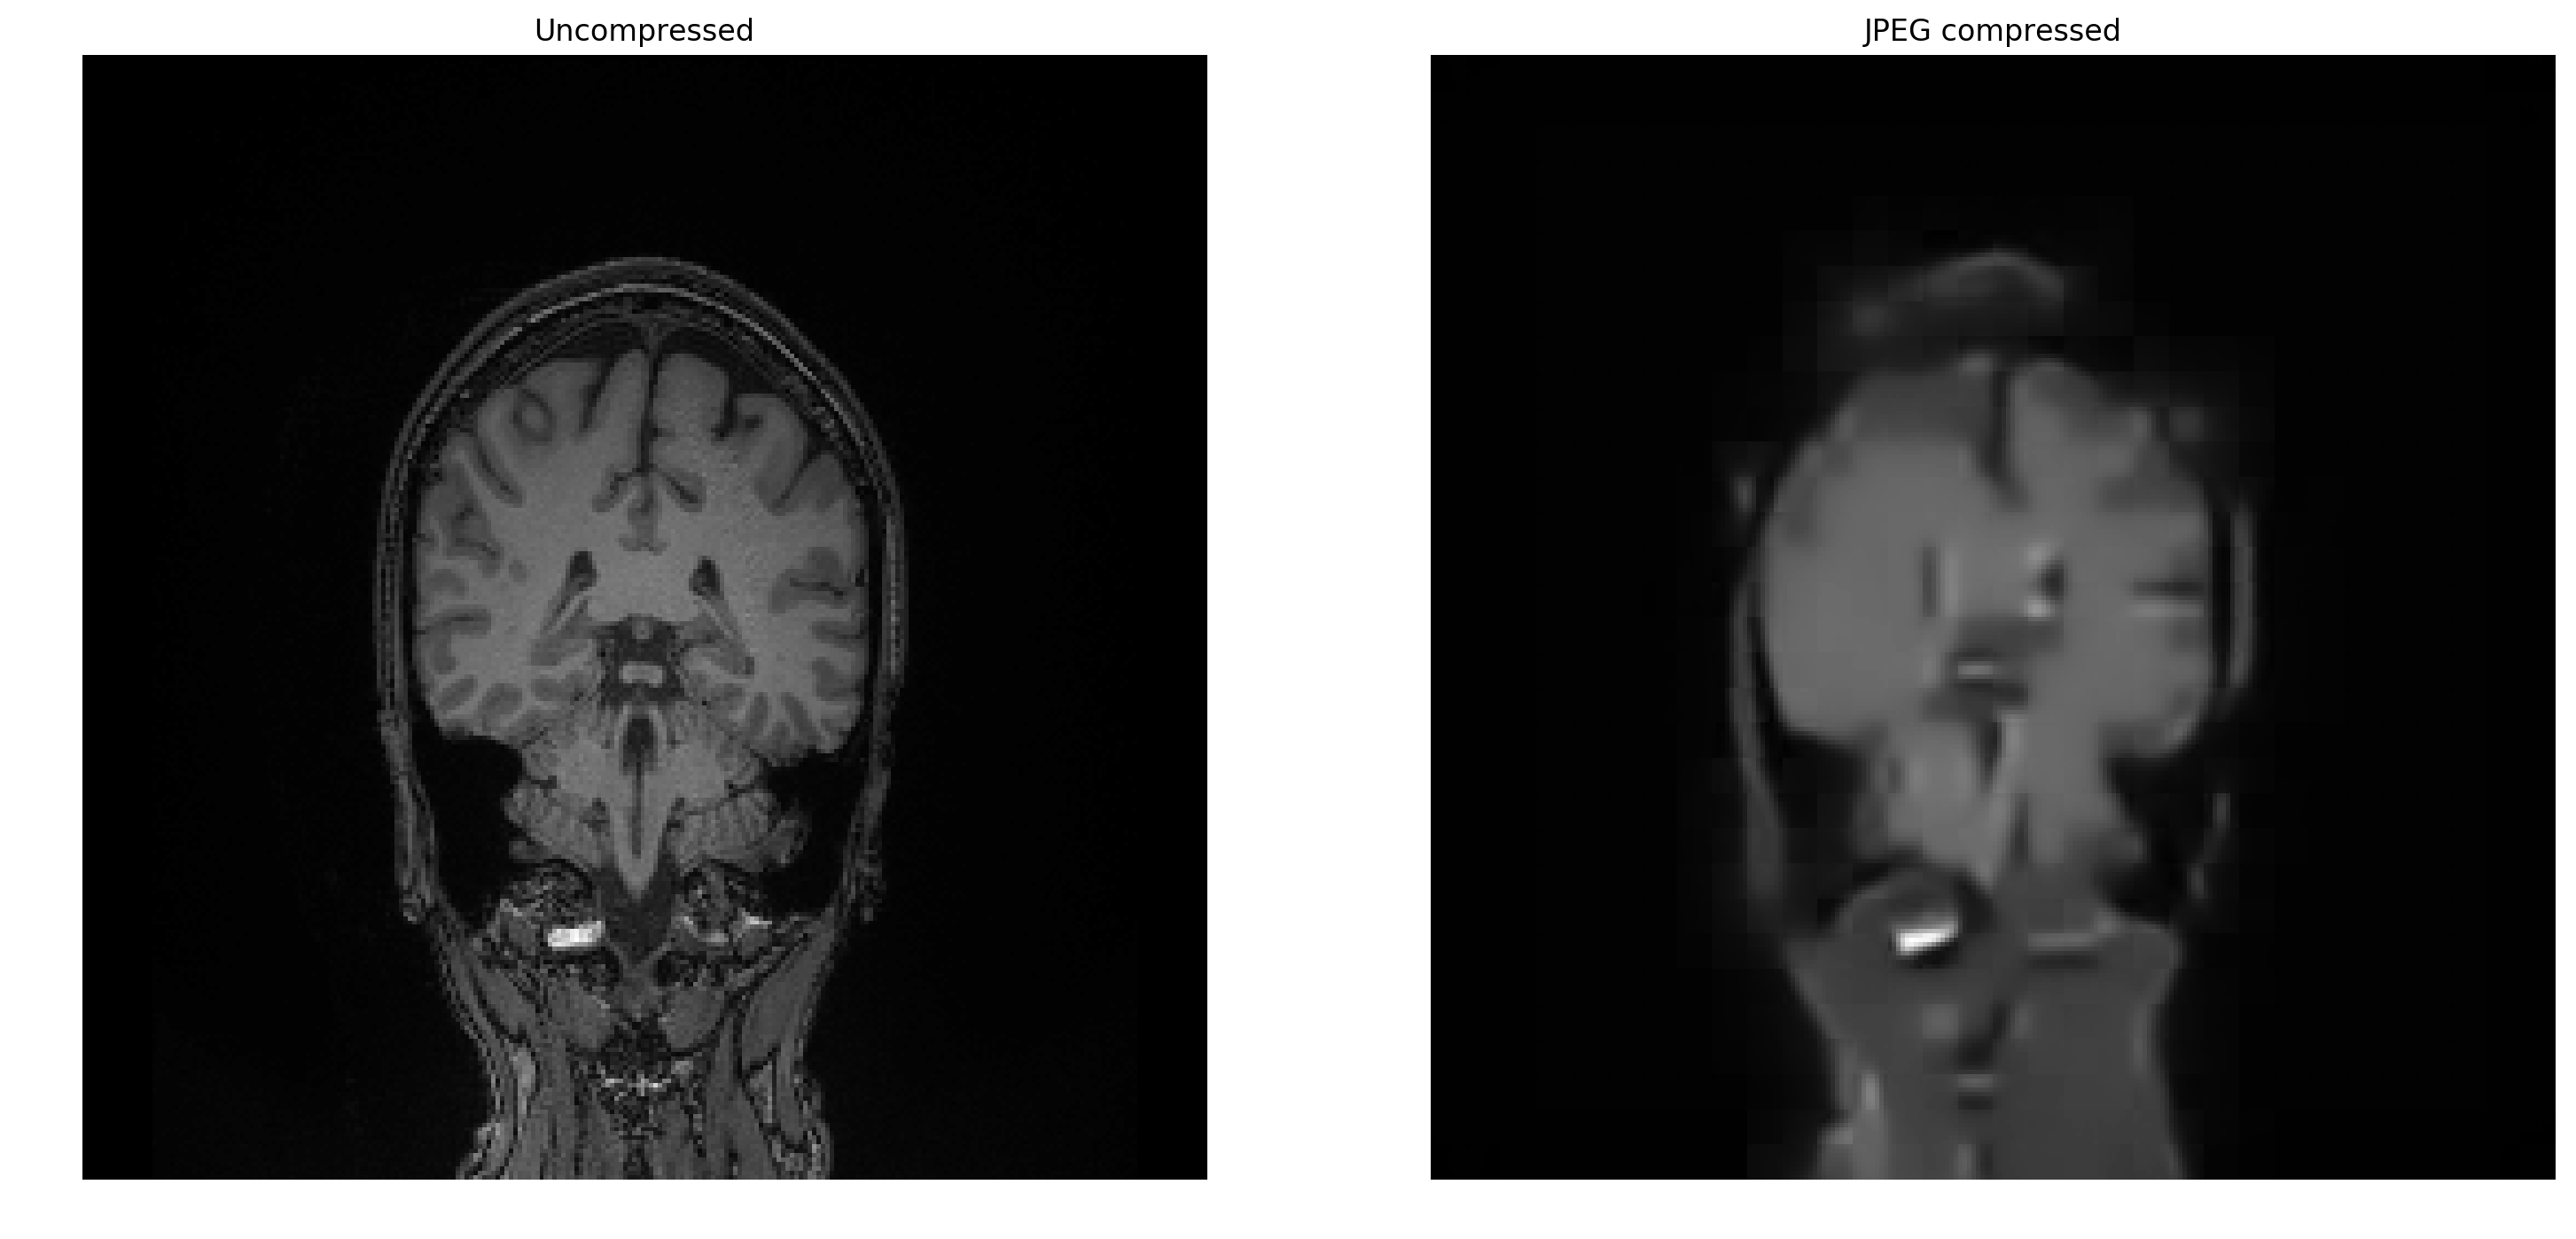

In [5]:
# Display the images
plt.figure(figsize=(18,9),dpi=200)
plt.subplot(1,2,1)
plt.imshow(train_unc[5660,:,:,0],cmap = "gray")
plt.axis("off")
plt.title("Uncompressed")
plt.subplot(1,2,2)
plt.imshow(train_compr[5660,:,:,0],cmap = "gray")
plt.axis("off")
plt.title("JPEG compressed")
plt.show()

In [6]:
num_network = 1

epochs = 30
batch_size= 8
model_name = "../Models/20190409-pretrained-residual_pseudo_wnet_i_data_augmentation_compress_5.hdf5"

# Early stopping callback to shut down training after 10 epochs with no improvement
earlyStopping = EarlyStopping(monitor='val_loss',
                                       patience=20, 
                                       verbose=0, mode='min')

checkpoint = ModelCheckpoint(model_name, mode = 'min', \
                                 monitor='val_loss',verbose=0,\
                                 save_best_only=True, save_weights_only = True)

if num_network == 1:
    depth_str ='i'
elif num_network == 2:
    depth_str = 'd'
elif num_network == 3:
    depth_str = 'di'
elif num_network == 4:
    depth_str = 'ii'
elif num_network == 5:
    depth_str = 'dd'
else:
    depth_str = 'ii'

opt = Adam(lr=0.0001)
model = deep_cascade_unet_no_dc(depth_str)
model.compile(loss = "mse",optimizer=opt)

model.load_weights("../Models/single_qf/20190403-imagenet-residual_pseudo_wnet_i_data_augmentation_compress_5.hdf5")

Instructions for updating:
Colocations handled automatically by placer.
0 i
Append U-net block


In [7]:
# seed = 905
# image_datagen1 = ImageDataGenerator(
#         rotation_range=40,
#         width_shift_range=0.075,
#         height_shift_range=0.075,
#         shear_range=0.25,
#         zoom_range=0.25,
#         horizontal_flip=True,
#         vertical_flip=True,
#         fill_mode='nearest')

# image_datagen1.fit(train_unc, augment=True, seed=seed)

# image_generator1 = image_datagen1.flow(train_unc,batch_size = batch_size,seed = seed)

# def combine_generator(gen1,compr_range, loadFromFile):
#     while True:
#         batch_unc = gen1.next()
#         batch_comp = np.zeros_like(batch_unc)

        
#         for ii in range(batch_unc.shape[0]):
#             # JPEG compress the image    
#             im1 = Image.fromarray(np.uint8(batch_unc[ii,:,:,0]))
#             buffer = io.BytesIO()
#             im1.save(buffer, "JPEG", quality=int(compr_range[ii]))
#             im2 = Image.open(buffer)
#             batch_comp[ii,:,:,0] = np.array(im2,dtype=np.float32)
            
#         yield((batch_comp-128.0)/128.0, (batch_unc.astype(np.float32)-128.0)/128.0)

# # combine generators into one which yields image and masks
# combined = combine_generator(image_generator1,compr_range)

batch_size= 8
seed = 905
image_datagen1 = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.075,
        height_shift_range=0.075,
        shear_range=0.25,
        zoom_range=0.25,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')

image_datagen1.fit(train_unc, augment=True, seed=seed)

image_generator1 = image_datagen1.flow(train_unc,batch_size = batch_size,seed = seed)
image_generator2 = image_datagen1.flow(train_compr,batch_size = batch_size,seed = seed)

def combine_generator(gen1,gen2):
    while True:
        batch_unc = gen1.next()
        batch_comp = gen2.next()
        
        yield(batch_comp, batch_unc)

# combine generators into one which yields image and masks
combined = combine_generator(image_generator1,image_generator2)

(8, 256, 256, 1)
-1.0367048 0.66260535
-1.0 0.69138557


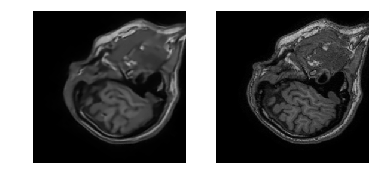

In [8]:
# sample data augmentation
for ii in combined:
    print(ii[0].shape)
    print(ii[0].min(),ii[0].max())
    print(ii[1].min(),ii[1].max())
    plt.figure()
    plt.subplot(121)
    plt.imshow(ii[0][2,:,:,0],cmap = 'gray',vmin=-1,vmax=1)
    plt.axis("off")
    plt.subplot(122)
    plt.imshow(ii[1][2,:,:,0],cmap = 'gray',vmin=-1,vmax=1)
    plt.axis("off")
    plt.show()
    break

In [9]:
hist = model.fit_generator(combined,
                 epochs=epochs,
                 steps_per_epoch=train_unc.shape[0] / batch_size,
                 verbose=1,
                 validation_data= (val_compr,val_unc),
                 callbacks=[checkpoint,earlyStopping])

Instructions for updating:
Use tf.cast instead.
Epoch 1/30
1343/1342 [==============================] - 131s 98ms/step - loss: 0.0031 - val_loss: 0.0042
Epoch 2/30
1343/1342 [==============================] - 127s 94ms/step - loss: 0.0030 - val_loss: 0.0042
Epoch 3/30
1343/1342 [==============================] - 127s 94ms/step - loss: 0.0030 - val_loss: 0.0042
Epoch 4/30
1343/1342 [==============================] - 127s 94ms/step - loss: 0.0030 - val_loss: 0.0042
Epoch 5/30
1343/1342 [==============================] - 127s 95ms/step - loss: 0.0030 - val_loss: 0.0042
Epoch 6/30
1343/1342 [==============================] - 127s 95ms/step - loss: 0.0030 - val_loss: 0.0042
Epoch 7/30
1343/1342 [==============================] - 127s 95ms/step - loss: 0.0030 - val_loss: 0.0042
Epoch 8/30
1343/1342 [==============================] - 127s 95ms/step - loss: 0.0030 - val_loss: 0.0042
Epoch 9/30
1343/1342 [==============================] - 127s 95ms/step - loss: 0.0030 - val_loss: 0.0042
Epoch 1

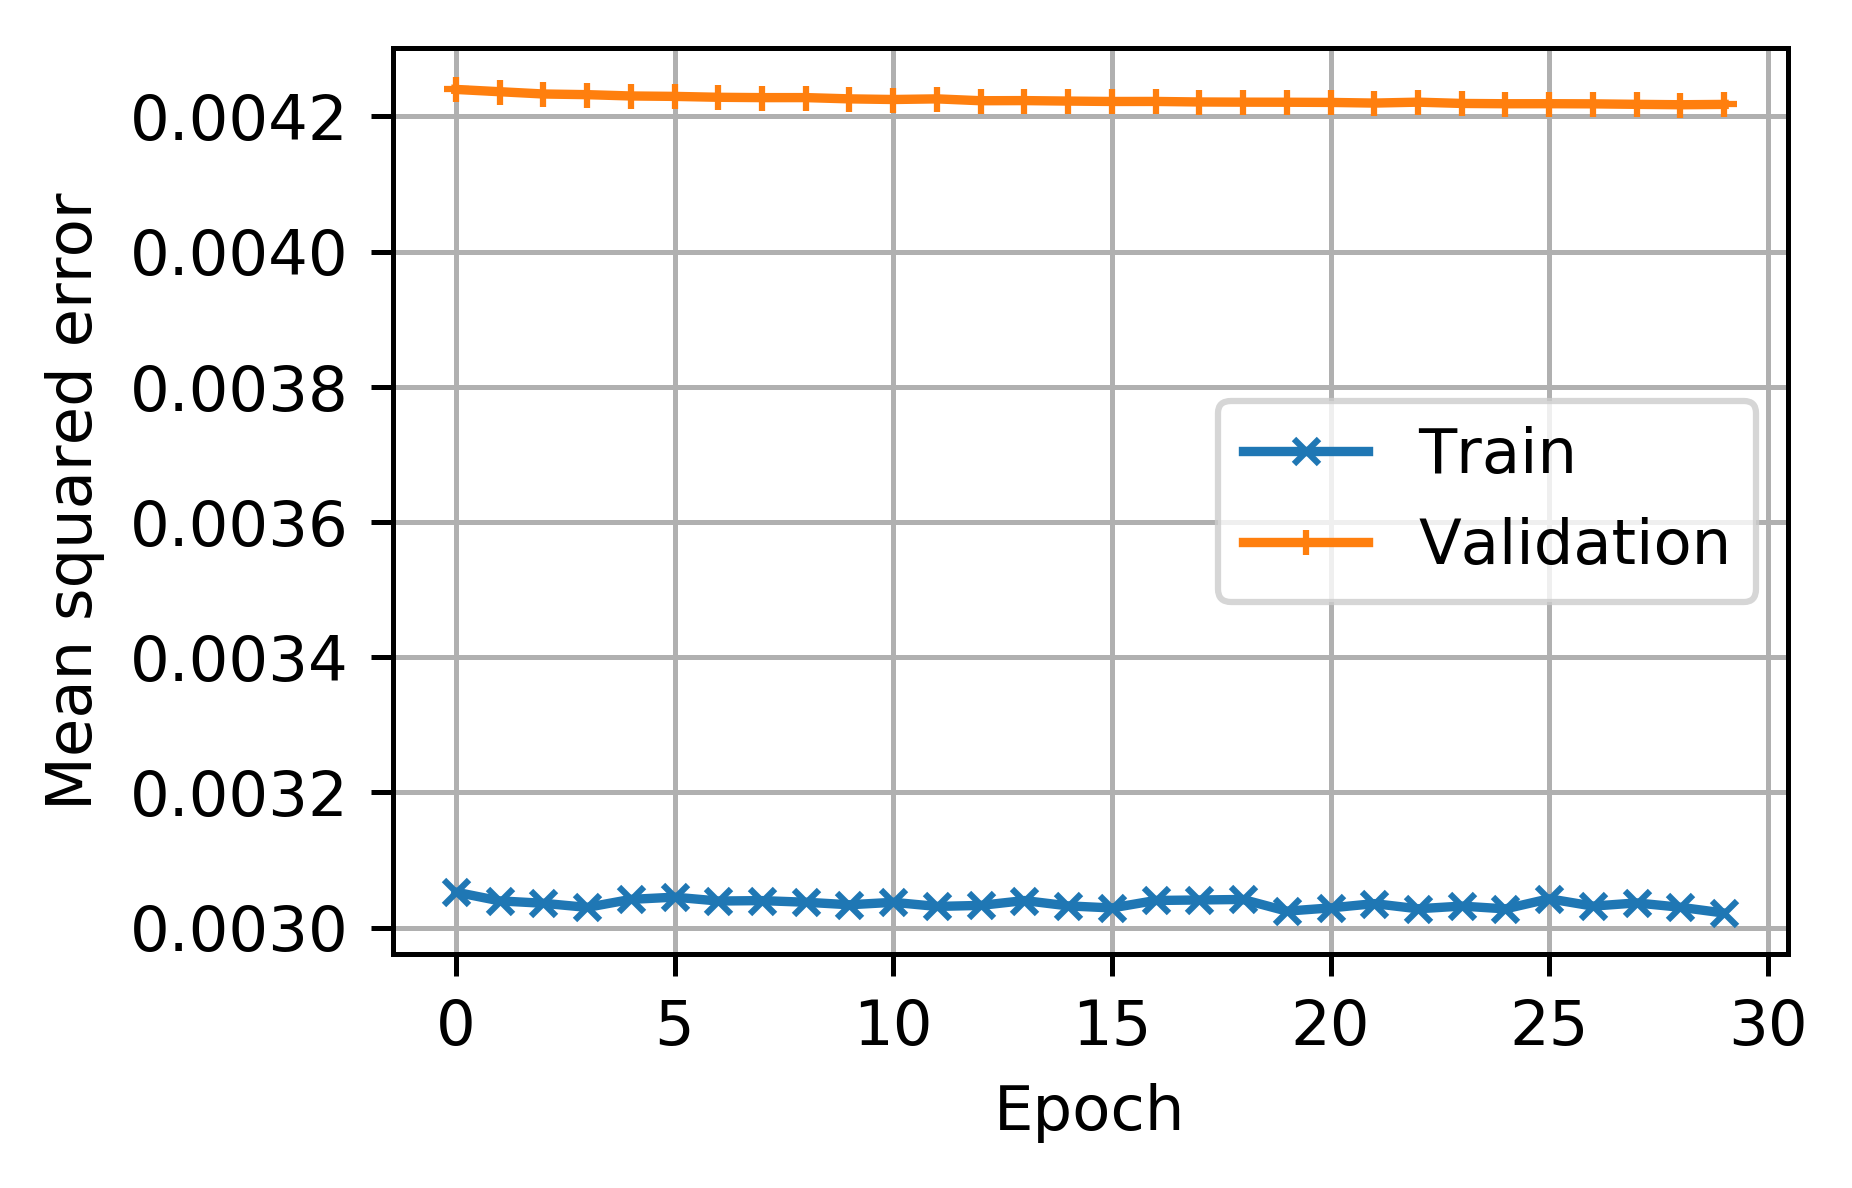

In [10]:
#Saving training history
np.save("../Data/single_qf/loss_residual_pseudo_wnet_i_data_augmentation_compress_5-pretrained.npy",np.array(hist.history['loss']))
np.save("../Data/single_qf/val_loss_residual_pseudo_wnet_ii_data_augmentation_compress_5-pretrained.npy",np.array(hist.history['val_loss']))

loss = np.array(hist.history['loss'])
val_loss = np.array(hist.history['val_loss'])
plt.figure(figsize = (4,4/1.5),facecolor = "w",dpi = 450)
plt.plot(loss,'x-', markersize = 4,label = "Train")
plt.plot(val_loss,'+-',markersize = 4,label = "Validation")
plt.legend()
plt.grid()
plt.xlabel("Epoch")
plt.ylabel("Mean squared error")
plt.show()

# Network D: Image-Image W-net

In [19]:
# Train and validation data paths
train_path = "/home/ubuntu/volume/volume1/TIFF/Development/Training/*.tif"
val_path = "/home/ubuntu/volume/volume1/TIFF/Development/Validation/*.tif"

# Listing train and validation images
train_images = glob.glob(train_path)
val_images = glob.glob(val_path)

# Summary of images
print("Train set size:", len(train_images))
print("Validation set size:",len(val_images))

Train set size: 10740
Validation set size: 5370


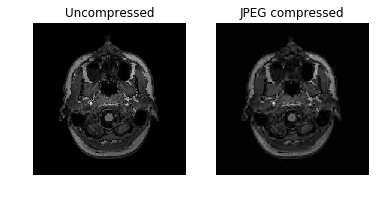

In [20]:
# Load uncompressed image
im1 = Image.open(train_images[200])
im1_array = np.array(im1)

# JPEG compress the image    
buffer = io.BytesIO()
im1.save(buffer, "JPEG", quality=15)
im2 = Image.open(buffer)
im2_array = np.array(im2)

# Display the images
plt.figure()
plt.subplot(121)
plt.imshow(im1_array,cmap = "gray")
plt.axis("off")
plt.title("Uncompressed")
plt.subplot(122)
plt.imshow(im2_array,cmap = "gray")
plt.axis("off")
plt.title("JPEG compressed")
plt.show()

In [21]:
H,W = 256, 256
norm = 255.0
compr_range = (5,6)

compr = np.random.choice(np.arange(compr_range[0],compr_range[1], dtype=int), \
                               len(train_images),replace = True)

# Train set
train_unc = np.zeros((len(train_images),H,W,1),dtype = np.float32)
for ii in range(len(train_images)):
    # Load uncompressed image
    im1 = Image.open(train_images[ii])
    train_unc[ii,:,:,0] = np.array(im1,dtype=np.float32)

    
compr_val = np.random.choice(np.arange(compr_range[0],compr_range[1], dtype=int), \
                               len(val_images),replace = True)

# Validation set
val_unc = np.zeros((len(val_images),H,W,1),dtype = np.float32)
val_compr = val_unc.copy()

for ii in range(len(val_images)):
    # Load uncompressed image
    im1 = Image.open(val_images[ii])
    val_unc[ii,:,:,0] = np.array(im1,dtype=np.float32)

    # JPEG compress the image    
    buffer = io.BytesIO()
    im1.save(buffer, "JPEG", quality=int(compr_val[ii]))
    im2 = Image.open(buffer)
    val_compr[ii,:,:,0] = np.array(im2,dtype=np.float32)


# Centre data around 0 and normalize to [-1, 1)
val_unc -= 128.0
val_compr -= 128.0

val_unc /= 128.0
val_compr /= 128.0

In [22]:
num_network = 4

epochs = 30
batch_size= 8
model_name = "../Models/20190408-pretrained-residual_wnet_ii_data_augmentation_compress_5.hdf5"

# Early stopping callback to shut down training after 10 epochs with no improvement
earlyStopping = EarlyStopping(monitor='val_loss',
                                       patience=20, 
                                       verbose=0, mode='min')

checkpoint = ModelCheckpoint(model_name, mode = 'min', \
                                 monitor='val_loss',verbose=0,\
                                 save_best_only=True, save_weights_only = True)

if num_network == 1:
    depth_str ='i'
elif num_network == 2:
    depth_str = 'd'
elif num_network == 3:
    depth_str = 'di'
elif num_network == 4:
    depth_str = 'ii'
elif num_network == 5:
    depth_str = 'dd'
else:
    depth_str = 'ii'

opt = Adam(lr=0.0001)
model = deep_cascade_unet_no_dc(depth_str)
model.compile(loss = "mse",optimizer=opt)

model.load_weights("../Models/single_qf/20190321-imagenet-residual_wnet_ii_data_augmentation_compress_5.hdf5")

0 i
Append U-net block
1 i
Append U-net block


In [23]:
seed = 905
image_datagen1 = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.075,
        height_shift_range=0.075,
        shear_range=0.25,
        zoom_range=0.25,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')

image_datagen1.fit(train_unc, augment=True, seed=seed)

image_generator1 = image_datagen1.flow(train_unc,batch_size = batch_size,seed = seed)

def combine_generator(gen1,compr_range):
    while True:
        batch_unc = gen1.next()
        batch_comp = np.zeros_like(batch_unc)

        for ii in range(batch_unc.shape[0]):
            # JPEG compress the image    
            im1 = Image.fromarray(np.uint8(batch_unc[ii,:,:,0]))
            buffer = io.BytesIO()
            im1.save(buffer, "JPEG", quality=int(compr[ii]))
            im2 = Image.open(buffer)
            batch_comp[ii,:,:,0] = np.array(im2,dtype=np.float32)
            
        yield((batch_comp-128.0)/128.0, (batch_unc.astype(np.float32)-128.0)/128.0)

# combine generators into one which yields image and masks
combined = combine_generator(image_generator1,compr_range)

(8, 256, 256, 1)
-1.0 0.9609375
-1.0 0.7414646


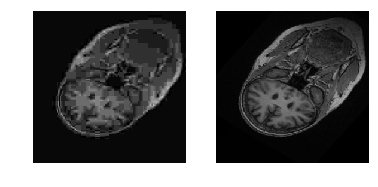

In [24]:
# sample data augmentation
for ii in combined:
    print(ii[0].shape)
    print(ii[0].min(),ii[0].max())
    print(ii[1].min(),ii[1].max())
    plt.figure()
    plt.subplot(121)
    plt.imshow(ii[0][2,:,:,0],cmap = 'gray',vmin=-1,vmax=1)
    plt.axis("off")
    plt.subplot(122)
    plt.imshow(ii[1][2,:,:,0],cmap = 'gray',vmin=-1,vmax=1)
    plt.axis("off")
    plt.show()
    break

In [25]:
hist = model.fit_generator(combined,
                 epochs=epochs,
                 steps_per_epoch=train_unc.shape[0] / batch_size,
                 verbose=1,
                 validation_data= (val_compr,val_unc),
                 callbacks=[checkpoint,earlyStopping])

Epoch 1/30
1343/1342 [==============================] - 252s 188ms/step - loss: 0.0030 - val_loss: 0.0042
Epoch 2/30
1343/1342 [==============================] - 248s 185ms/step - loss: 0.0030 - val_loss: 0.0042
Epoch 3/30
1343/1342 [==============================] - 249s 185ms/step - loss: 0.0030 - val_loss: 0.0042
Epoch 4/30
1343/1342 [==============================] - 249s 185ms/step - loss: 0.0030 - val_loss: 0.0042
Epoch 5/30
1343/1342 [==============================] - 249s 185ms/step - loss: 0.0030 - val_loss: 0.0042
Epoch 6/30
1343/1342 [==============================] - 249s 185ms/step - loss: 0.0030 - val_loss: 0.0041
Epoch 7/30
1343/1342 [==============================] - 249s 186ms/step - loss: 0.0029 - val_loss: 0.0041
Epoch 8/30
1343/1342 [==============================] - 249s 186ms/step - loss: 0.0029 - val_loss: 0.0041
Epoch 9/30
1343/1342 [==============================] - 249s 186ms/step - loss: 0.0029 - val_loss: 0.0041
Epoch 10/30
1343/1342 [=======================

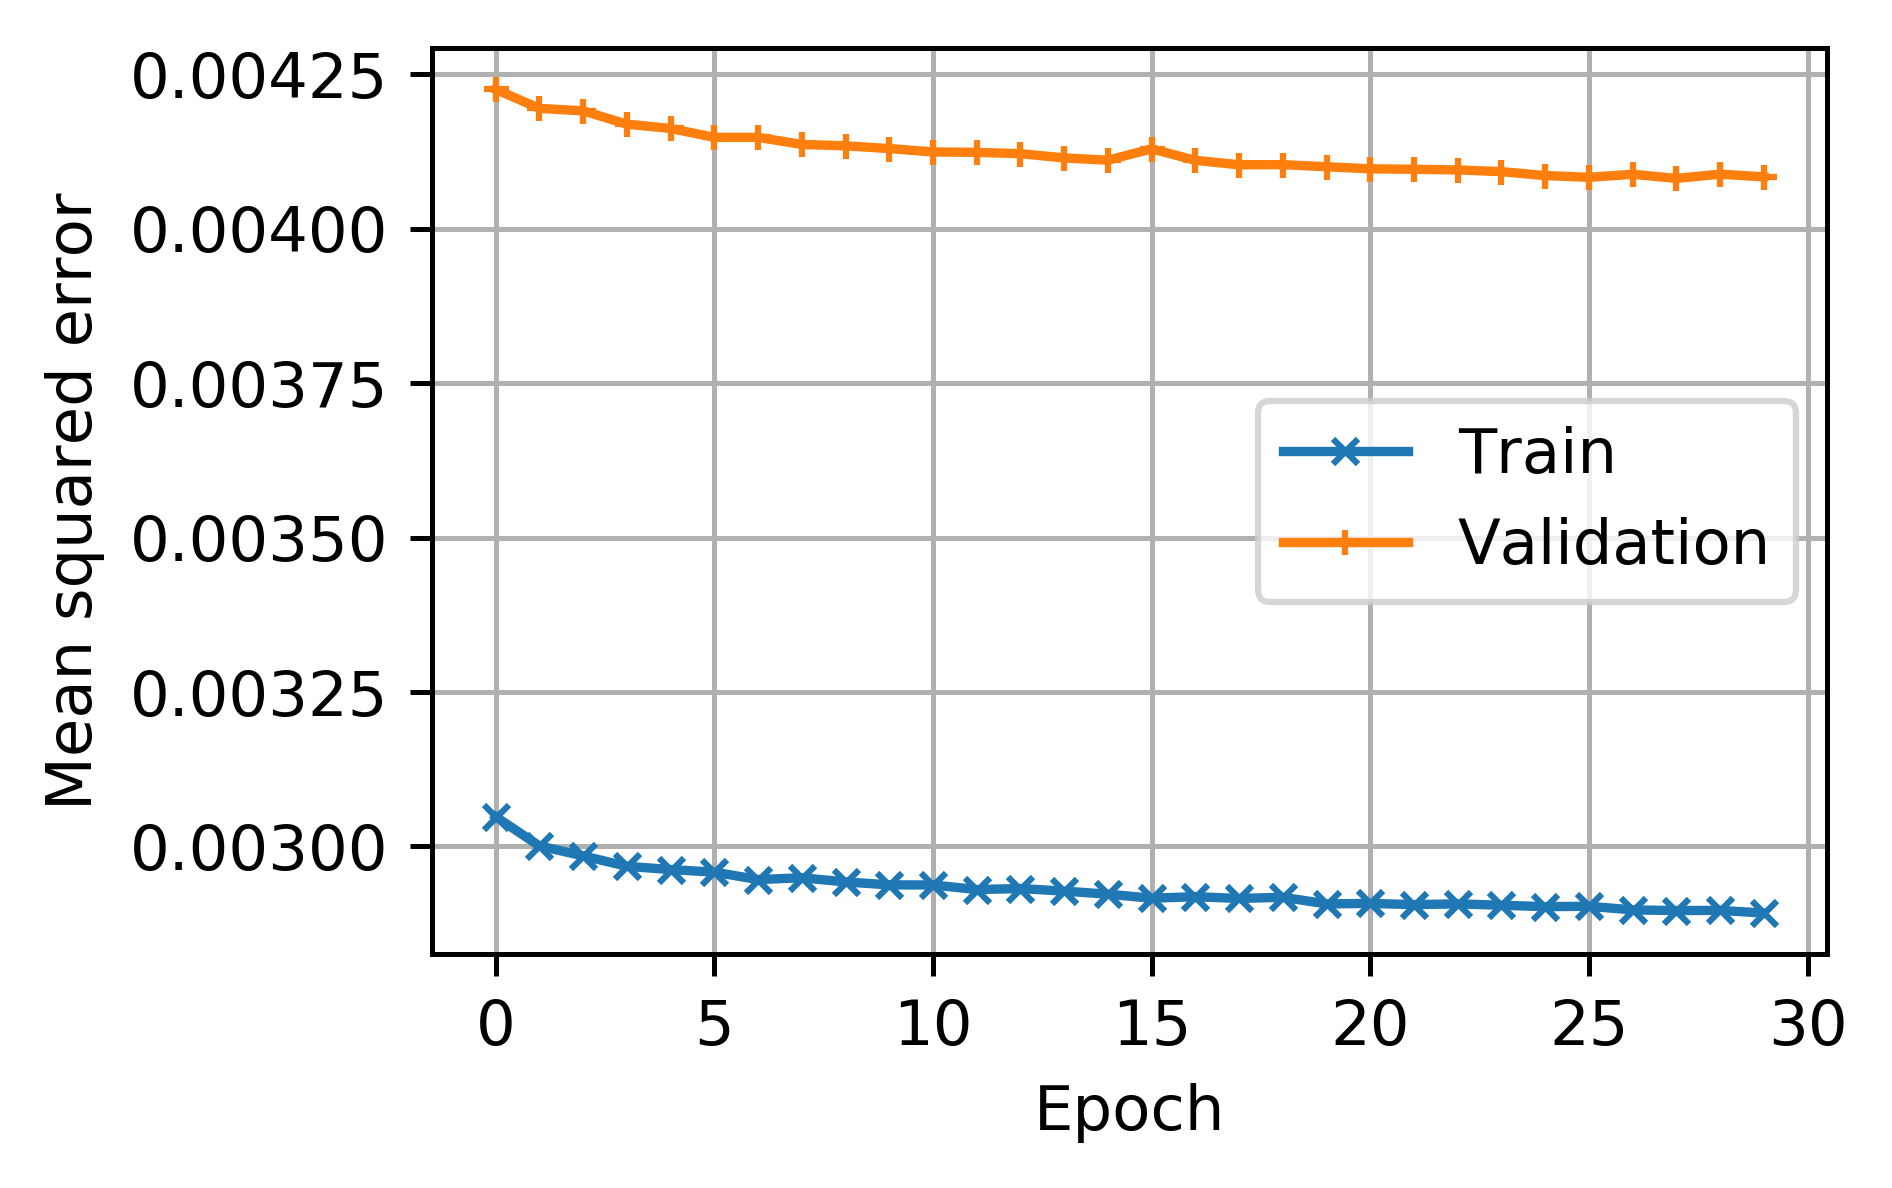

In [26]:
#Saving training history
np.save("../Data/single_qf/loss_residual_wnet_ii_data_augmentation_compress_5-pretrained.npy",np.array(hist.history['loss']))
np.save("../Data/single_qf/val_loss_residual_wnet_ii_data_augmentation_compress_5-pretrained.npy",np.array(hist.history['val_loss']))

loss = np.array(hist.history['loss'])
val_loss = np.array(hist.history['val_loss'])
plt.figure(figsize = (4,4/1.5),facecolor = "w",dpi = 450)
plt.plot(loss,'x-', markersize = 4,label = "Train")
plt.plot(val_loss,'+-',markersize = 4,label = "Validation")
plt.legend()
plt.grid()
plt.xlabel("Epoch")
plt.ylabel("Mean squared error")
plt.show()

# Network E: DCT-DCT W-net

In [27]:
# Train and validation data paths
train_path = "/home/ubuntu/volume/volume1/TIFF/Development/Training/*.tif"
val_path = "/home/ubuntu/volume/volume1/TIFF/Development/Validation/*.tif"

# Listing train and validation images
train_images = glob.glob(train_path)
val_images = glob.glob(val_path)

# Summary of images
print("Train set size:", len(train_images))
print("Validation set size:",len(val_images))

Train set size: 10740
Validation set size: 5370


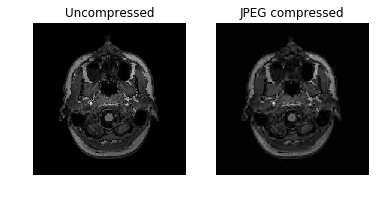

In [28]:
# Load uncompressed image
im1 = Image.open(train_images[200])
im1_array = np.array(im1)

# JPEG compress the image    
buffer = io.BytesIO()
im1.save(buffer, "JPEG", quality=15)
im2 = Image.open(buffer)
im2_array = np.array(im2)

# Display the images
plt.figure()
plt.subplot(121)
plt.imshow(im1_array,cmap = "gray")
plt.axis("off")
plt.title("Uncompressed")
plt.subplot(122)
plt.imshow(im2_array,cmap = "gray")
plt.axis("off")
plt.title("JPEG compressed")
plt.show()

In [29]:
H,W = 256, 256
norm = 255.0
compr_range = (5,6)

compr = np.random.choice(np.arange(compr_range[0],compr_range[1], dtype=int), \
                               len(train_images),replace = True)

# Train set
train_unc = np.zeros((len(train_images),H,W,1),dtype = np.float32)
for ii in range(len(train_images)):
    # Load uncompressed image
    im1 = Image.open(train_images[ii])
    train_unc[ii,:,:,0] = np.array(im1,dtype=np.float32)

    
compr_val = np.random.choice(np.arange(compr_range[0],compr_range[1], dtype=int), \
                               len(val_images),replace = True)

# Validation set
val_unc = np.zeros((len(val_images),H,W,1),dtype = np.float32)
val_compr = val_unc.copy()

for ii in range(len(val_images)):
    # Load uncompressed image
    im1 = Image.open(val_images[ii])
    val_unc[ii,:,:,0] = np.array(im1,dtype=np.float32)

    # JPEG compress the image    
    buffer = io.BytesIO()
    im1.save(buffer, "JPEG", quality=int(compr_val[ii]))
    im2 = Image.open(buffer)
    val_compr[ii,:,:,0] = np.array(im2,dtype=np.float32)


# Centre data around 0 and normalize to [-1, 1)
val_unc -= 128.0
val_compr -= 128.0

val_unc /= 128.0
val_compr /= 128.0

In [30]:
# DCT of validation set
dct_val_unc = val_unc.copy()
dct_val_compr = val_unc.copy()

for ii in range(len(val_images)):
    dct_val_unc[ii,:,:,0] = dct_in_blocks(val_unc[ii,:,:,0])
    dct_val_compr[ii,:,:,0] = dct_in_blocks(val_compr[ii,:,:,0])

In [31]:
num_network = 4

epochs = 30
batch_size= 8
model_name = "../Models/single_qf/20190408-pretrained-residual_wnet_dd_data_augmentation_compress_5.hdf5"

# Early stopping callback to shut down training after 10 epochs with no improvement
earlyStopping = EarlyStopping(monitor='val_loss',
                                       patience=20, 
                                       verbose=0, mode='min')

checkpoint = ModelCheckpoint(model_name, mode = 'min', \
                                 monitor='val_loss',verbose=0,\
                                 save_best_only=True, save_weights_only = True)

if num_network == 1:
    depth_str ='i'
elif num_network == 2:
    depth_str = 'd'
elif num_network == 3:
    depth_str = 'di'
elif num_network == 4:
    depth_str = 'ii'
elif num_network == 5:
    depth_str = 'dd'
else:
    depth_str = 'ii'

opt = Adam(lr=0.0001)
model = deep_cascade_unet_no_dc(depth_str)
model.compile(loss = "mse",optimizer=opt)

model.load_weights("../Models/single_qf/20190404-imagenet-residual_wnet_dd_data_augmentation_compress_5.hdf5")

0 i
Append U-net block
1 i
Append U-net block


In [32]:
# Data augmentation
# Question - should we take the DCT of the augmented image or augment the DCT matrix?
# Mar 6 --> Try augmenting the DCT matrix image
# augment before or after DCT?

seed = 905
image_datagen1 = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.075,
        height_shift_range=0.075,
        shear_range=0.25,
        zoom_range=0.25,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')

image_datagen1.fit(train_unc, augment=True, seed=seed)

image_generator1 = image_datagen1.flow(train_unc,batch_size = batch_size,seed = seed)

def combine_generator(gen1,compr_range):
    while True:
        batch_unc = gen1.next()
        batch_comp = np.zeros_like(batch_unc)
        
        dct_batch_unc = batch_unc.copy()
        dct_batch_comp = batch_comp.copy()

        compr = np.random.choice(np.arange(compr_range[0],compr_range[1], dtype=int), \
                               batch_unc.shape[0],replace = True)

        for ii in range(batch_unc.shape[0]):
            # JPEG compress the image    
            im1 = Image.fromarray(np.uint8(batch_unc[ii,:,:,0]))
            buffer = io.BytesIO()
            im1.save(buffer, "JPEG", quality=int(compr[ii]))
            im2 = Image.open(buffer)
            batch_comp[ii,:,:,0] = np.array(im2,dtype=np.float32)

            dct_batch_unc[ii,:,:,0] = dct_in_blocks((batch_unc[ii,:,:,0].astype(np.float32)-128.0)/128.0)
            dct_batch_comp[ii,:,:,0] = dct_in_blocks((batch_comp[ii,:,:,0].astype(np.float32)-128.0)/128.0)
            
        yield(dct_batch_comp, dct_batch_unc)

# combine generators into one which yields image and masks
combined = combine_generator(image_generator1,compr_range)

(8, 256, 256, 1)
-7.5 4.2980566
-7.9999995 3.9439158


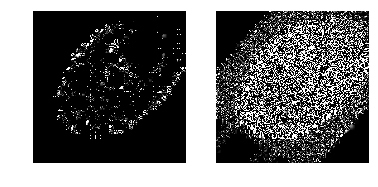

In [33]:
# sample data augmentation
for ii in combined:
    print(ii[0].shape)
    print(ii[0].min(),ii[0].max())
    print(ii[1].min(),ii[1].max())
    plt.figure()
    plt.subplot(121)
    plt.imshow(ii[0][2,:,:,0],cmap = 'gray',vmin=0,vmax=1/128.0)
    plt.axis("off")
    plt.subplot(122)
    plt.imshow(ii[1][2,:,:,0],cmap = 'gray',vmin=0,vmax=1/128.0)
    plt.axis("off")
    plt.show()
    break

In [34]:
hist = model.fit_generator(combined,
                 epochs=epochs,
                 steps_per_epoch=train_unc.shape[0] / batch_size,
                 verbose=1,
                 validation_data= (dct_val_compr,dct_val_unc),
                 callbacks=[checkpoint,earlyStopping])

Epoch 1/30
1343/1342 [==============================] - 485s 361ms/step - loss: 0.0031 - val_loss: 0.0043
Epoch 2/30
1343/1342 [==============================] - 480s 358ms/step - loss: 0.0030 - val_loss: 0.0042
Epoch 3/30
1343/1342 [==============================] - 479s 356ms/step - loss: 0.0030 - val_loss: 0.0042
Epoch 4/30
1343/1342 [==============================] - 479s 357ms/step - loss: 0.0030 - val_loss: 0.0042
Epoch 5/30
1343/1342 [==============================] - 482s 359ms/step - loss: 0.0030 - val_loss: 0.0042
Epoch 6/30
1343/1342 [==============================] - 478s 356ms/step - loss: 0.0030 - val_loss: 0.0042
Epoch 7/30
1343/1342 [==============================] - 480s 357ms/step - loss: 0.0030 - val_loss: 0.0042
Epoch 8/30
1343/1342 [==============================] - 478s 356ms/step - loss: 0.0030 - val_loss: 0.0042
Epoch 9/30
1343/1342 [==============================] - 481s 358ms/step - loss: 0.0030 - val_loss: 0.0042
Epoch 10/30
1343/1342 [=======================

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1343/1342 [==============================] - 479s 356ms/step - loss: 0.0029 - val_loss: 0.0041
Epoch 30/30
1343/1342 [==============================] - 480s 358ms/step - loss: 0.0029 - val_loss: 0.0041


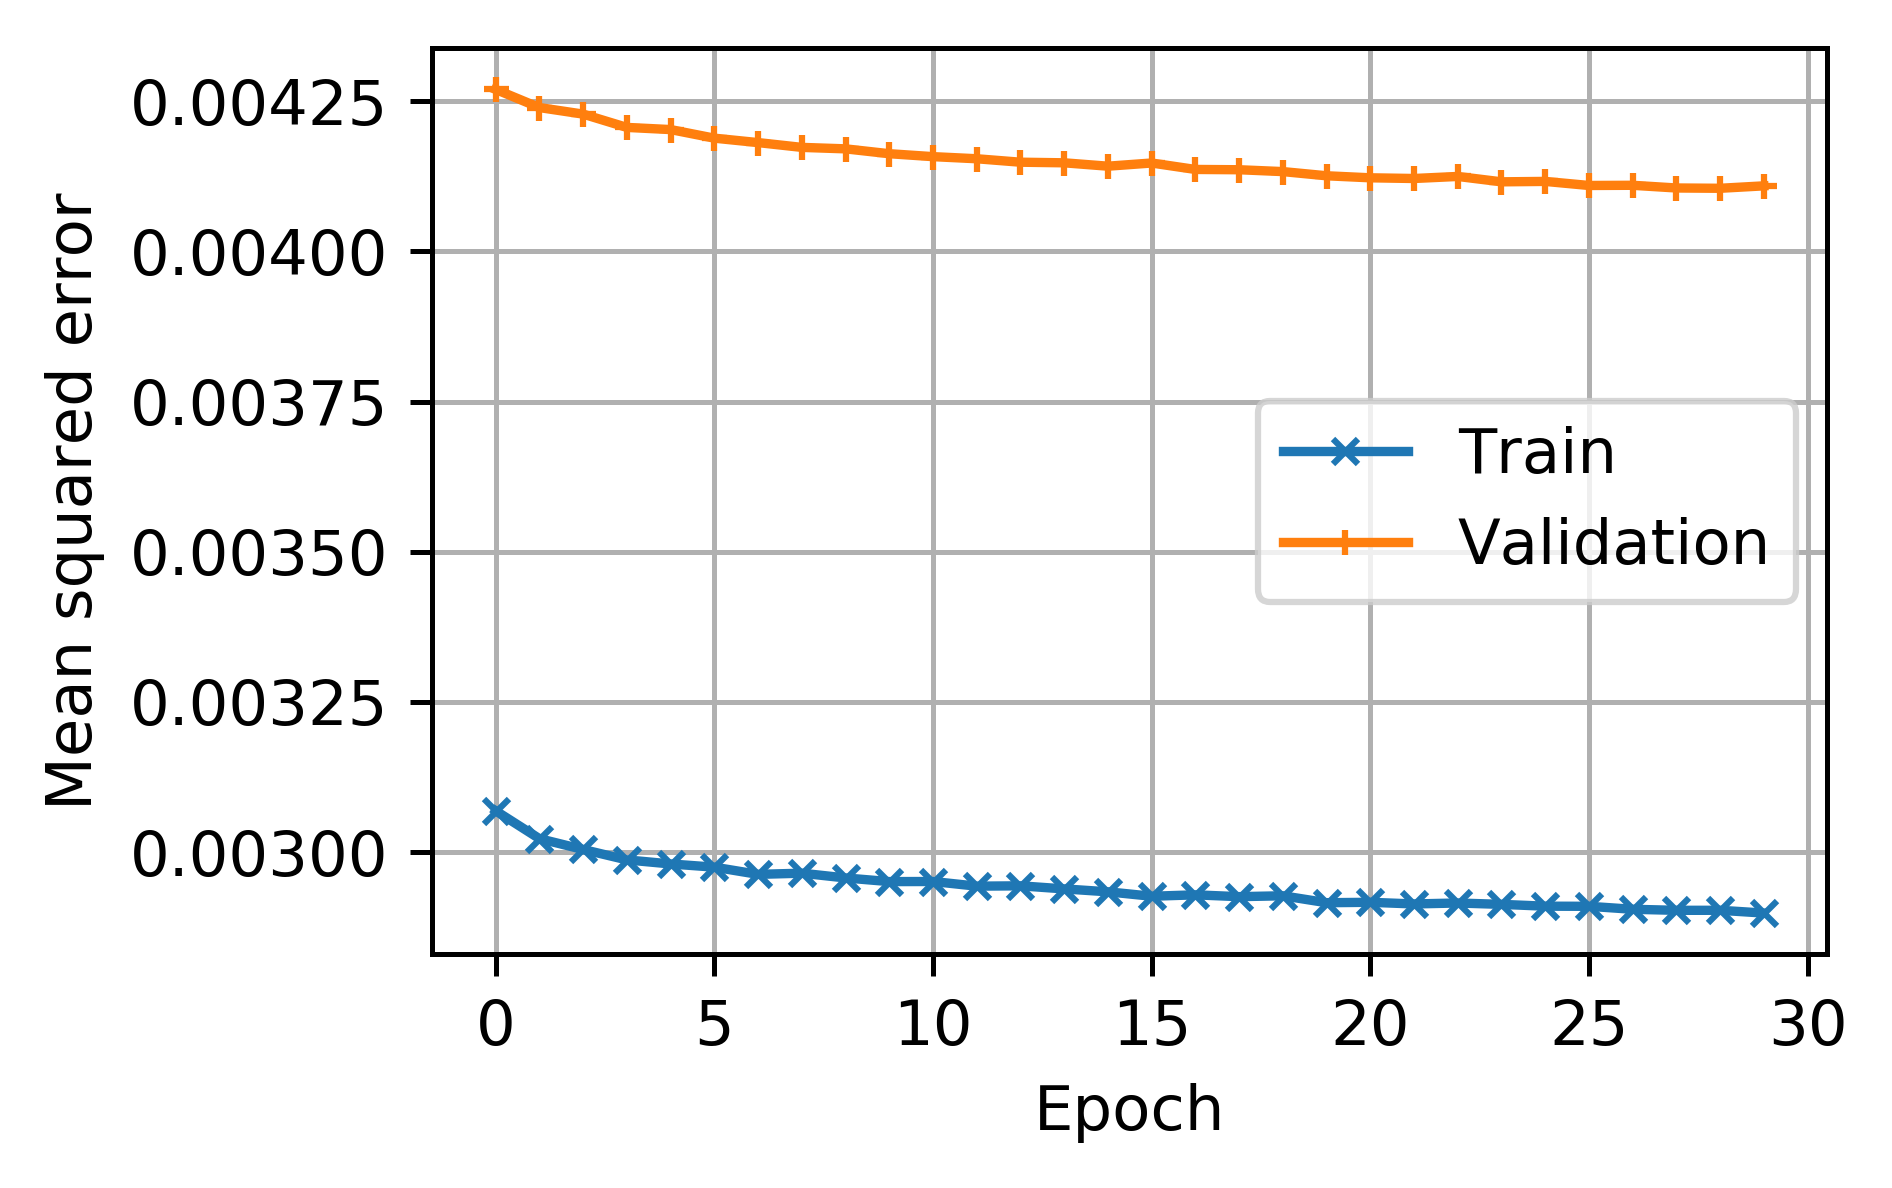

In [35]:
#Saving training history
np.save("../Data/single_qf/loss_residual_wnet_dd_data_augmentation_compress_5-pretrained.npy",np.array(hist.history['loss']))
np.save("../Data/single_qf/val_loss_residual_wnet_dd_data_augmentation_compress_5-pretrained.npy",np.array(hist.history['val_loss']))

loss = np.array(hist.history['loss'])
val_loss = np.array(hist.history['val_loss'])
plt.figure(figsize = (4,4/1.5),facecolor = "w",dpi = 450)
plt.plot(loss,'x-', markersize = 4,label = "Train")
plt.plot(val_loss,'+-',markersize = 4,label = "Validation")
plt.legend()
plt.grid()
plt.xlabel("Epoch")
plt.ylabel("Mean squared error")
plt.show()

In [ ]:
epochs = 30
batch_size= 8
model_name = "../Models/residual_wnet_dd_data_augmentation_compress_15-imagenet.hdf5"

# Early stopping callback to shut down training after 10 epochs with no improvement
earlyStopping = EarlyStopping(monitor='val_loss',
                                       patience=20, 
                                       verbose=0, mode='min')

checkpoint = ModelCheckpoint(model_name, mode = 'min', \
                                 monitor='val_loss',verbose=0,\
                                 save_best_only=True, save_weights_only = True)


opt = Adam(lr=0.001)
model = deep_cascade_unet_no_dc(depth_str='dd')
model.compile(loss = "mse",optimizer=opt)

In [ ]:
# sample data augmentation
for ii in combined:
    print(ii[0].shape)
    print(ii[0].min(),ii[0].max())
    print(ii[1].min(),ii[1].max())
    plt.figure()
    plt.subplot(121)
    plt.imshow(ii[0][2,:,:,0],cmap = 'gray',vmin=-1,vmax=1)
    plt.axis("off")
    plt.subplot(122)
    plt.imshow(ii[1][2,:,:,0],cmap = 'gray',vmin=-1,vmax=1)
    plt.axis("off")
    plt.show()
    break

In [ ]:
hist = model.fit_generator(combined,
                 epochs=epochs,
                 steps_per_epoch=train_unc.shape[0] / batch_size,
                 verbose=1,
                 validation_data= (val_compr,val_unc),
                 callbacks=[checkpoint,earlyStopping])

In [ ]:
#Saving training history
np.save("../Data/loss_residual_wnet_dd_data_augmentation_compress_15-imagenet.npy",np.array(hist.history['loss']))
np.save("../Data/val_loss_residual_wnet_dd_data_augmentation_compress_15-imagenet.npy",np.array(hist.history['val_loss']))

loss = np.array(hist.history['loss'])
val_loss = np.array(hist.history['val_loss'])
plt.figure(figsize = (4,4/1.5),facecolor = "w",dpi = 450)
plt.plot(loss,'x-', markersize = 4,label = "Train")
plt.plot(val_loss,'+-',markersize = 4,label = "Validation")
plt.legend()
plt.grid()
plt.xlabel("Epoch")
plt.ylabel("Mean squared error")
plt.show()

In [ ]:
epochs = 30
batch_size= 8
model_name = "../Models/residual_wnet_ii_data_augmentation_compress_15-imagenet.hdf5"

# Early stopping callback to shut down training after 10 epochs with no improvement
earlyStopping = EarlyStopping(monitor='val_loss',
                                       patience=20, 
                                       verbose=0, mode='min')

checkpoint = ModelCheckpoint(model_name, mode = 'min', \
                                 monitor='val_loss',verbose=0,\
                                 save_best_only=True, save_weights_only = True)


opt = Adam(lr=0.001)
model = deep_cascade_unet_no_dc(depth_str='ii')
model.compile(loss = "mse",optimizer=opt)

In [ ]:
# sample data augmentation
for ii in combined:
    print(ii[0].shape)
    print(ii[0].min(),ii[0].max())
    print(ii[1].min(),ii[1].max())
    plt.figure()
    plt.subplot(121)
    plt.imshow(ii[0][2,:,:,0],cmap = 'gray',vmin=-1,vmax=1)
    plt.axis("off")
    plt.subplot(122)
    plt.imshow(ii[1][2,:,:,0],cmap = 'gray',vmin=-1,vmax=1)
    plt.axis("off")
    plt.show()
    break

In [ ]:
hist = model.fit_generator(combined,
                 epochs=epochs,
                 steps_per_epoch=train_unc.shape[0] / batch_size,
                 verbose=1,
                 validation_data= (val_compr,val_unc),
                 callbacks=[checkpoint,earlyStopping])

In [ ]:
#Saving training history
np.save("../Data/loss_residual_wnet_ii_data_augmentation_compress_15-imagenet.npy",np.array(hist.history['loss']))
np.save("../Data/val_loss_residual_wnet_ii_data_augmentation_compress_15-imagenet.npy",np.array(hist.history['val_loss']))

loss = np.array(hist.history['loss'])
val_loss = np.array(hist.history['val_loss'])
plt.figure(figsize = (4,4/1.5),facecolor = "w",dpi = 450)
plt.plot(loss,'x-', markersize = 4,label = "Train")
plt.plot(val_loss,'+-',markersize = 4,label = "Validation")
plt.legend()
plt.grid()
plt.xlabel("Epoch")
plt.ylabel("Mean squared error")
plt.show()

In [ ]:
epochs = 30
batch_size= 8
model_name = "../Models/residual_unet_d_data_augmentation_compress_15-imagenet.hdf5"

# Early stopping callback to shut down training after 10 epochs with no improvement
earlyStopping = EarlyStopping(monitor='val_loss',
                                       patience=20, 
                                       verbose=0, mode='min')

checkpoint = ModelCheckpoint(model_name, mode = 'min', \
                                 monitor='val_loss',verbose=0,\
                                 save_best_only=True, save_weights_only = True)


opt = Adam(lr=0.001)
model = deep_cascade_unet_no_dc(depth_str='d')
model.compile(loss = "mse",optimizer=opt)

In [ ]:
# sample data augmentation
for ii in combined:
    print(ii[0].shape)
    print(ii[0].min(),ii[0].max())
    print(ii[1].min(),ii[1].max())
    plt.figure()
    plt.subplot(121)
    plt.imshow(ii[0][2,:,:,0],cmap = 'gray',vmin=-1,vmax=1)
    plt.axis("off")
    plt.subplot(122)
    plt.imshow(ii[1][2,:,:,0],cmap = 'gray',vmin=-1,vmax=1)
    plt.axis("off")
    plt.show()
    break

In [ ]:
hist = model.fit_generator(combined,
                 epochs=epochs,
                 steps_per_epoch=train_unc.shape[0] / batch_size,
                 verbose=1,
                 validation_data= (val_compr,val_unc),
                 callbacks=[checkpoint,earlyStopping])

In [ ]:
#Saving training history
np.save("../Data/loss_residual_unet_d_data_augmentation_compress_15-imagenet.npy",np.array(hist.history['loss']))
np.save("../Data/val_loss_residual_unet_d_data_augmentation_compress_15-imagenet.npy",np.array(hist.history['val_loss']))

loss = np.array(hist.history['loss'])
val_loss = np.array(hist.history['val_loss'])
plt.figure(figsize = (4,4/1.5),facecolor = "w",dpi = 450)
plt.plot(loss,'x-', markersize = 4,label = "Train")
plt.plot(val_loss,'+-',markersize = 4,label = "Validation")
plt.legend()
plt.grid()
plt.xlabel("Epoch")
plt.ylabel("Mean squared error")
plt.show()

In [ ]:
epochs = 30
batch_size= 8
model_name = "../Models/residual_unet_i_data_augmentation_compress_15-imagenet.hdf5"

# Early stopping callback to shut down training after 10 epochs with no improvement
earlyStopping = EarlyStopping(monitor='val_loss',
                                       patience=20, 
                                       verbose=0, mode='min')

checkpoint = ModelCheckpoint(model_name, mode = 'min', \
                                 monitor='val_loss',verbose=0,\
                                 save_best_only=True, save_weights_only = True)


opt = Adam(lr=0.001)
model = deep_cascade_unet_no_dc(depth_str='i')
model.compile(loss = "mse",optimizer=opt)

In [ ]:
# sample data augmentation
for ii in combined:
    print(ii[0].shape)
    print(ii[0].min(),ii[0].max())
    print(ii[1].min(),ii[1].max())
    plt.figure()
    plt.subplot(121)
    plt.imshow(ii[0][2,:,:,0],cmap = 'gray',vmin=-1,vmax=1)
    plt.axis("off")
    plt.subplot(122)
    plt.imshow(ii[1][2,:,:,0],cmap = 'gray',vmin=-1,vmax=1)
    plt.axis("off")
    plt.show()
    break

In [ ]:
hist = model.fit_generator(combined,
                 epochs=epochs,
                 steps_per_epoch=train_unc.shape[0] / batch_size,
                 verbose=1,
                 validation_data= (val_compr,val_unc),
                 callbacks=[checkpoint,earlyStopping])

In [ ]:
#Saving training history
np.save("../Data/loss_residual_unet_i_data_augmentation_compress_15-imagenet.npy",np.array(hist.history['loss']))
np.save("../Data/val_loss_residual_unet_i_data_augmentation_compress_15-imagenet.npy",np.array(hist.history['val_loss']))

loss = np.array(hist.history['loss'])
val_loss = np.array(hist.history['val_loss'])
plt.figure(figsize = (4,4/1.5),facecolor = "w",dpi = 450)
plt.plot(loss,'x-', markersize = 4,label = "Train")
plt.plot(val_loss,'+-',markersize = 4,label = "Validation")
plt.legend()
plt.grid()
plt.xlabel("Epoch")
plt.ylabel("Mean squared error")
plt.show()

In [ ]:
from scipy.fftpack import dct as DCT, idct as IDCT

def py_dct2d(im):
    return DCT(DCT(im,type=2,axis=0,norm='ortho'),type=2,axis=1,norm='ortho')
def py_idct2d(mat):
    return IDCT(IDCT(mat,type=2,axis=0,norm='ortho'),type=2,axis=1,norm='ortho')

def dct_in_blocks(im, block_size = 8):

    rows, cols = im.shape[0], im.shape[1]

    # block size: 8x8
    if rows % block_size == cols % block_size == 0:
        blocks_count = rows // block_size * cols // block_size
    else:
        raise ValueError(("the width and height of the image "
                          "should both be mutiples of %block_size"))

    dct_matrix = np.zeros((rows, cols))

    for i in range(0, rows, block_size):
        for j in range(0, cols, block_size):

            block = im[i:i+block_size, j:j+block_size]
            dct_matrix[i:i+block_size,j:j+block_size] = py_dct2d(block)

    return dct_matrix

def tf_dct_in_blocks(im, block_size = 8):

    rows, cols = im.shape[0], im.shape[1]

    # block size: 8x8
    if rows % block_size == cols % block_size == 0:
        blocks_count = rows // block_size * cols // block_size
    else:
        raise ValueError(("the width and height of the image "
                          "should both be mutiples of %block_size"))

    dct_matrix = np.zeros((rows, cols))

    for i in range(0, rows, block_size):
        for j in range(0, cols, block_size):

            block = im[i:i+block_size, j:j+block_size]
            dct_matrix[i:i+block_size,j:j+block_size] = dct2d(block)

    return dct_matrix

def idct_in_blocks(dct_mat, block_size = 8):

    rows, cols = dct_mat.shape[0], dct_mat.shape[1]

    # block size: 8x8
    if rows % block_size == cols % block_size == 0:
        blocks_count = rows // block_size * cols // block_size
    else:
        raise ValueError(("the width and height of the image "
                          "should both be mutiples of %block_size"))

    im_matrix = np.zeros((rows, cols))

    for i in range(0, rows, block_size):
        for j in range(0, cols, block_size):

            block = dct_mat[i:i+block_size, j:j+block_size]
            im_matrix[i:i+block_size,j:j+block_size] = py_idct2d(block)

    return im_matrix


In [ ]:
from keras import backend as K
def tf_dct2d(im):
    return K.tf.transpose(K.tf.spectral.dct(K.tf.transpose(K.tf.spectral.dct(im,type=2,axis=-1,norm='ortho')),axis=-1,norm='ortho'))
    
    
def tf_idct2d(mat):
    return K.tf.transpose(K.tf.spectral.idct(K.tf.transpose(K.tf.spectral.idct(mat,type=2,axis=-1,norm='ortho')),axis=-1,norm='ortho'))


# Modified from:
# https://stackoverflow.com/questions/44047753/reconstructing-an-image-after-using-extract-image-patches
def extract_patches(x):
    return K.tf.extract_image_patches(
        x,
        (1, 8, 8, 1),
        (1, 8, 8, 1),
        (1, 1, 1, 1),
        padding="SAME"
    )


def extract_patches_inverse(x, y):
    _x = K.tf.zeros_like(x)
    _y = extract_patches(_x)
    grad = K.tf.gradients(_y, _x)[0]
    # Divide by grad, to "average" together the overlapping patches
    # otherwise they would simply sum up
    return K.tf.gradients(_y, _x, grad_ys=y)[0] / grad


In [ ]:
# Testing stuff
length = 3

tens = np.zeros((length, 256,256,1), dtype=np.float32)
for ii in range(length):
    im1 = Image.open(train_images[ii*150])
    im1_array = np.array(im1)
    
    tens[ii,:,:,0] = im1_array
    
patches = extract_patches(tens)
dct_patches = tf_dct2d(patches)
tf_dct_image = extract_patches_inverse(tens, dct_patches)

dct_patches_2 = extract_patches(tf_dct_image)
img_patches = tf_idct2d(dct_patches_2)
tf_image = extract_patches_inverse(tens,img_patches)

np_tf_dct_image = tf_eval(tf_dct_image)
np_tf_image = tf_eval(tf_image)

for ii in range(length):
    plt.figure(figsize=(18,9))
    plt.subplot(length,3,3*ii+1)
    plt.imshow(tens[ii,:,:,0],cmap = "gray")
    plt.axis("off")
    plt.title("Original Image")
    plt.subplot(length,3,3*ii+2)
    plt.imshow(np_tf_dct_image[ii,:,:,0],cmap = "gray",vmin=0,vmax=1)
    plt.axis("off")
    plt.title("TF DCT")
    plt.subplot(length,3,3*ii+3)
    plt.imshow(np_tf_image[ii,:,:,0],cmap = "gray")
    plt.axis("off")
    plt.title("TF IDCT")
plt.show()

In [ ]:
# Testing stuff
length = 3

tens = np.zeros((length, 256,256,1), dtype=np.float32)
for ii in range(length):
    im1 = Image.open(train_images[ii*150])
    im1_array = np.array(im1)
    
    tens[ii,:,:,0] = im1_array

py_dct_img = py_dct2d(im1_array)
tf_dct_img = K.tf.transpose(K.tf.spectral.dct(K.tf.transpose(K.tf.spectral.dct(im1_array,type=2,axis=-1,norm='ortho')),axis=-1,norm='ortho'))

py_img = py_idct2d(py_dct_img)
tf_img = K.tf.transpose(K.tf.spectral.idct(K.tf.transpose(K.tf.spectral.idct(tf_dct_img,type=2,axis=-1,norm='ortho')),axis=-1,norm='ortho'))

plt.figure(figsize=(18,9))
plt.subplot(length,3,1)
plt.imshow(tf_eval(tf_dct_img),cmap = "gray",vmin=0,vmax=1)
plt.axis("off")
plt.title("TF DCT")
plt.subplot(length,3,2)
plt.imshow(py_dct_img,cmap = "gray",vmin=0,vmax=1)
plt.axis("off")
plt.title("PY DCT")
plt.subplot(length,3,4)
plt.imshow(tf_eval(tf_img),cmap = "gray")
plt.axis("off")
plt.title("TF IDCT")
plt.subplot(length,3,5)
plt.imshow(py_img,cmap = "gray")
plt.axis("off")
plt.title("PY IDCT")
plt.show()

mse = ((py_dct_img - tf_eval(tf_dct_img))**2).mean(axis=None)

print("TF DCT: ", np.mean(tf_eval(tf_dct_img)), np.min(tf_eval(tf_dct_img)), np.max(tf_eval(tf_dct_img)))
print("PY DCT: ", np.mean(py_dct_img), np.min(py_dct_img), np.max(py_dct_img))
print("TF IDCT: ", np.mean(tf_eval(tf_img)), np.min(tf_eval(tf_img)), np.max(tf_eval(tf_img)))
print("PY IDCT: ", np.mean(py_img), np.min(py_img), np.max(py_img))
#print(py_dct_img == tf_eval(tf_dct_img))
print(mse)

# py_dct_image = tens.copy()
# tf_dct_image = tens.copy()
# for ii in range(length):
#     py_dct_image[ii,:,:,0] = py_dct2d(tens[ii,:,:,0])
#     tf_dct_image[ii,:,:,0] = tf_dct2d(tens[ii,:,:,0])

# # py_dct_image = tens.copy()
# # tf_dct_image = tens.copy()
# # for ii in range(length):
# #     py_dct_image[ii,:,:,0] = dct_in_blocks(tens[ii,:,:,0])
# #     tf_dct_image = tf_dct_in_blocks(tens[ii,:,:,0])


# # patches = extract_patches(tens)
# # dct_patches = dct2d(patches)
# # tf_dct_image = extract_patches_inverse(tens, dct_patches)

# print(tf_dct_image.eval)
# test = tf_eval(tf_dct_image)
# # Display the images
# plt.figure(figsize=(18,9))
# for ii in range(length):
#     plt.subplot(length,3,3*ii+1)
#     plt.imshow(tens[ii,:,:,0],cmap = "gray")
#     plt.axis("off")
#     plt.title("Uncompressed")
#     plt.subplot(length,3,3*ii+2)
#     plt.imshow(py_dct_image[ii,:,:,0],cmap = "gray",vmin=0,vmax=1)
#     plt.axis("off")
#     plt.title("Python DCT")
#     plt.subplot(length,3,3*ii+3)
#     plt.imshow(test[ii,:,:,0],cmap = "gray",vmin=0,vmax=1)
#     plt.axis("off")
#     plt.title("TF DCT")
# plt.show()